In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from tqdm.auto import tqdm
import concurrent.futures
from multiprocessing import Pool
import copy, os, sys
from collections import Counter
import itertools
# from zac_pyutils.ExqUtils import zprint

# Tensorflow API解释

In [3]:
# import psutil
import tensorflow as tf
# import tensorflow_hub as hub

# 一些基本的配置

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # 禁用GPU

In [6]:
# 允许GPU渐进占用
sess_conf = tf.ConfigProto()
sess_conf.gpu_options.allow_growth = True  # 允许GPU渐进占用
sess_conf.allow_soft_placement = True  # 把不适合GPU的放到CPU上跑
with tf.Session(config=sess_conf) as sess:
    print(sess)

In [7]:
# sess.run(.. options=run_opt)可以在OOM的时候提供当前已经声明了的变量
run_opt = tf.RunOptions()
run_opt.report_tensor_allocations_upon_oom = True

In [51]:
g_sess = tf.Session()

# 基本数据类型

## Sparse 
- SparseTensor vs SparseTensorValue

sess.run(xx_sp) 的结果就是一个 `SparseTensorValue`

- SparseTensorValue to SparseTensor

`tf.sparse.SparseTensor(i['wideFeatures'].indices,i['wideFeatures'].values,i['wideFeatures'].dense_shape)`

关于 `tf.spase.slice` 本日志里也有记录，直接搜索 | [官方API解释](https://tensorflow.google.cn/api_docs/python/tf/sparse/slice)

```
tf.sparse.slice(
    sp_input, start, size, name=None
)
```

# DataSet API
参考 [知乎这篇文章的介绍](https://zhuanlan.zhihu.com/p/30751039)

主要就关注两个基础类 `Dataset` 和 `Iterator`
- `tf.data.Dataset.from_tensor_slices` 接受一个`ndarray`
- 得到的结果记为`dataset`，通过`dataset.make_one_shot_iterator()`得到一个「只遍历一次」的 `iterator`


## 从多种数据源中创建DataSet

In [36]:
samplesCnt = 15
# 字典
data = {"a": np.random.randint(0,9,size=[samplesCnt]),
        "b": np.random.randint(20,30,size=(samplesCnt, 2))}
# tuple
data = (np.random.randint(0,9,size=[samplesCnt]),
        np.random.randint(20,30,size=(samplesCnt, 2)))
# 普通的多维数组
data = np.random.randint(0,99,size=[samplesCnt,4])

In [43]:
print(">>> 只用了data的 top4 元素")
print(">>>data:\n",data[:4])
dataset = tf.data.Dataset.from_tensor_slices(data[:4])
one_shot = dataset.make_one_shot_iterator()
with tf.Session() as sess:
    for i in range(6):
        try:
            print(f">>> get_next at idx-{i}\n", sess.run(one_shot.get_next()))
        except tf.errors.OutOfRangeError:
            print(">>> [ERROR]: depleted")
    

>>> 只用了data的 top4 元素
>>>data:
 [[58 64 15 71]
 [52 10  7 54]
 [17 14 67 83]
 [11 79 92 31]]
>>> get_next at idx-0
 [58 64 15 71]
>>> get_next at idx-1
 [52 10  7 54]
>>> get_next at idx-2
 [17 14 67 83]
>>> get_next at idx-3
 [11 79 92 31]
>>> [ERROR]: depleted
>>> [ERROR]: depleted


## Dataset的batch等操作
`.shuffle`的参数`buffer_size` 控制从多少来源里采样
> representing the number of elements from this dataset from which the new dataset will sample

`.batch`的参数`drop_remainder` 控制最后一个batch如果不够batch_size，是否要扔掉
- `True` shape ==> `((64, 100), (64, 100))`。
- `False`shape ==> `((?,100),(?,100))`
> representing the number of consecutive elements of this dataset to combine in a single batch.

还可以做`fitler`、`map`、`repeat` 等操作

In [46]:
print(f">>>data: {data.shape}\n",data)
# 这里用len(data)做buffer_size表示shuffle是全集里采样
batch_size=3
dataset = tf.data.Dataset.from_tensor_slices(data).batch(3).shuffle(buffer_size=len(data))  
one_shot = dataset.make_one_shot_iterator()
with tf.Session() as sess:
    for i in range(6):
        try:
            print(f">>> get_next at [idx]:{i} [batch_size]:{batch_size}\n", sess.run(one_shot.get_next()))
        except tf.errors.OutOfRangeError:
            print(">>> [ERROR]: depleted")

>>>data: (15, 4)
 [[58 64 15 71]
 [52 10  7 54]
 [17 14 67 83]
 [11 79 92 31]
 [79 22 57 15]
 [18 60  5 66]
 [ 8 27  5 46]
 [64 10 49 25]
 [72 35 90 91]
 [16 27 93 86]
 [70 48 45 48]
 [66 66 51 86]
 [23 23 88 57]
 [76 84 59 74]
 [ 7 66 15  6]]
>>> get_next at [idx]:0 [batch_size]:3
 [[ 8 27  5 46]
 [64 10 49 25]
 [72 35 90 91]]
>>> get_next at [idx]:1 [batch_size]:3
 [[23 23 88 57]
 [76 84 59 74]
 [ 7 66 15  6]]
>>> get_next at [idx]:2 [batch_size]:3
 [[11 79 92 31]
 [79 22 57 15]
 [18 60  5 66]]
>>> get_next at [idx]:3 [batch_size]:3
 [[58 64 15 71]
 [52 10  7 54]
 [17 14 67 83]]
>>> get_next at [idx]:4 [batch_size]:3
 [[16 27 93 86]
 [70 48 45 48]
 [66 66 51 86]]
>>> [ERROR]: depleted


## Dataset2Iterator

主要有四种做法：
- make_one_shot_iterator

写demo常用

- initializable iterator

一般读很大的数组时会用这个，避免把大数组存在计算图里（*`from_tensor_slices`本质是把`array`作为一个`tf.constants`存到了计算图里*)
> - initializable iterator必须要在使用前通过sess.run()来初始化
> - 使用initializable iterator，可以将placeholder代入Iterator中，这可以方便我们通过参数快速定义新的Iterator

```python
limit = tf.placeholder(dtype=tf.int32, shape=[])
dataset = tf.data.Dataset.from_tensor_slices(tf.range(start=0, limit=limit))
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer, feed_dict={limit: 10})
    for i in range(10):
        value = sess.run(next_element)
        assert i == value
```

- reinitializable iterator
- feedable iterator


# 模型保存与恢复

一个常规ckpt保存目录的一般是：
```python
xxx_ckpt/
  |__ checkpoint  # 这是个txt记录了有哪些ckpt
  |__ b7i1.ckpt.meta
  |__ b7i1.ckpt.index
  |__ b7i1.ckpt.data-0000-of-0001
  |__ b6....
```

`.meta`里存的是计算图

`.data`存的是变量数据

如果只有`xxx.ckpt`，一般是需要手动构建一下计算图然后再`saver.restore(sess, "xx.ckpt")`

[长文关于保存与加载模型及inception模型示例](https://github.com/strivebo/DeepLearning_Notes_CV/blob/master/Notes/08-%E4%BF%9D%E5%AD%98%E5%92%8C%E8%BD%BD%E5%85%A5%E6%A8%A1%E5%9E%8B%EF%BC%8C%E4%BD%BF%E7%94%A8Google%E7%9A%84%E5%9B%BE%E5%83%8F%E8%AF%86%E5%88%AB%E7%BD%91%E7%BB%9Cinception-v3%E8%BF%9B%E8%A1%8C%E5%9B%BE%E5%83%8F%E8%AF%86%E5%88%AB.md)
- 这个里面他是直接下载了inception的pb模型文件

In [ ]:
saver = tf.train.Saver()
saver.save(sess,"xxx")

## 预训练模型的加载

### TF Slim 系列的API

v1 提示 `InvalidArgumentError`
```python
InvalidArgumentError: Can not squeeze dim[1], expected a dimension of 1, got 2 for 'InceptionV1/Logits/SpatialSqueeze' (op: 'Squeeze') with input shapes: [?,2,2,1000].
```

v3 提示 `NotFoundErr` 已经提交issue

v4 这个版本(tf=1.15)都没有实现 inception_v4

In [16]:
from tensorflow.contrib.slim.python.slim.nets import inception
from tensorflow.contrib import slim
import tensorflow as tf
ckpt_fp = "./tmp/CBIR/inception_v3.ckpt"
# ckpt_fp = "/Users/zac/Downloads/cv_models/inception_v3.ckpt"
g = tf.Graph()
with g.as_default():
    sess = tf.Session(graph=g)
    input_image = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3], name="input")
    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, end_points = inception.inception_v3(input_image, is_training=False)
    f_vec = end_points['PreLogits']  # (N, 2048)
    f_vec
#    saver = tf.train.Saver()
#    saver.restore(sess, ckpt_fp)

INFO:tensorflow:Restoring parameters from ./tmp/CBIR/inception_v3.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Tensor name "InceptionV3/AuxLogits/Conv2d_2a_3x3/BatchNorm/beta" not found in checkpoint files ./tmp/CBIR/inception_v3.ckpt
	 [[node save/RestoreV2 (defined at /home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'save/RestoreV2':
  File "/home/zhoutong/python3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zhoutong/python3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zhoutong/python3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zhoutong/python3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/zhoutong/python3/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/zhoutong/python3/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/zhoutong/python3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/zhoutong/python3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2907, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/zhoutong/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-52e58957930b>", line 13, in <module>
    saver = tf.train.Saver()
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/training/saver.py", line 828, in __init__
    self.build()
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/training/saver.py", line 840, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/training/saver.py", line 878, in _build
    build_restore=build_restore)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/training/saver.py", line 508, in _build_internal
    restore_sequentially, reshape)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/training/saver.py", line 328, in _AddRestoreOps
    restore_sequentially)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/training/saver.py", line 575, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_io_ops.py", line 1696, in restore_v2
    name=name)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/zhoutong/python3/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


### TF Hub 系列

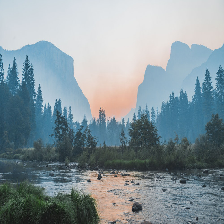

(1, 224, 224, 3)

In [40]:
from zac_pyutils import CVUtils
img = CVUtils.Load.image_by_pil_from("https://images.unsplash.com/photo-1506744038136-46273834b3fb?ixlib=rb-1.2.1&w=1000&q=80")
img = img.resize((224,224))
img
image_batch = np.array(img)[np.newaxis,:] / 255.0
image_batch.shape

#### 模型存储在本地的地址

In [ ]:
url = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4'
hub.module_v2.resolve(url)

#### hub.KerasLayer加载

In [53]:
tf.reset_default_graph()
# 加载 | 这个版本不支持 hub.Module 加载模型
url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
model = tf.keras.Sequential([hub.KerasLayer(url, trainable=False)])
IMAGE_SHAPE = (224, 224)
# 拿到特征向量
res = model.predict(image_batch)  # img_batch.shape: [N,224,224,3]
print(f"预测特征向量结果 shape:{res.shape}\n",res)

预测特征向量结果 shape:(1, 2048)
 [[0.06628775 0.10215072 0.19079387 ... 0.06903157 0.1981493  1.3962605 ]]


keras加载的模型只能直接用结果了，不论从计算图还是遍历名字都看不出什么可用的

slim里的inception结构保存的计算图更符合原论文直观印象，并且endpoints里很多都可用

In [48]:
k_sess=tf.keras.backend.get_session()
k_g = k_sess.graph
[i for i in k_g.get_operations() if "out" in i.name]

[]

#### hub.Module加载

In [57]:
tf.reset_default_graph()
module = hub.Module("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/3")
height, width = hub.get_expected_image_size(module)
images = tf.placeholder(dtype=tf.float32,shape=[None,224,224,3],name="img_input_custom")  # A batch of images with shape [batch_size, height, width, 3].
features = module(images)  # Features with shape [batch_size, num_features].
# features 是一个tensor
sess = tf.Session()
with sess:
    sess.run(tf.global_variables_initializer())
    res = sess.run(features,feed_dict={images:image_batch})
    print(f"预测特征向量结果 shape:{res.shape}\n",res)

预测特征向量结果 shape:(1, 2048)
 [[0.0427991  0.02400407 0.12483396 ... 0.02483537 0.1095883  0.        ]]


In [51]:
[i for i in tf.get_default_graph().get_operations() if "out" in i.name]

[<tf.Operation 'module/hub_output/feature_vector/SpatialSqueeze' type=Squeeze>,
 <tf.Operation 'module_apply_default/hub_output/feature_vector/SpatialSqueeze' type=Squeeze>]

## 拿到模型做点别的操作

### 增加一层 "add_on_op"

例子一：
[SO上一个关于什么时候初始化saver导致的问题](https://stackoverflow.com/questions/45120672/tensorflow-how-to-restore-a-inception-v3-pre-trained-network-weights-after-havi)
> Important: The saver = tf_saver.Saver () must be instantiated before adding new layers to the graph.
>
> This way, when the saver.restore(sess, FLAGS.checkpoint) is performed, it only knows the computation graph prior to creating new layers.

参考自 [TensorFlow加载预训练模型 | CSDN博客](https://blog.csdn.net/huachao1001/article/details/78501928)
```python
import tensorflow as tf

sess = tf.Session()
# 先加载图和变量
saver = tf.train.import_meta_graph('my_test_model-1000.meta')
saver.restore(sess, tf.train.latest_checkpoint('./'))

# 访问placeholders变量，并且创建feed-dict来作为placeholders的新值
graph = tf.get_default_graph()
w1 = graph.get_tensor_by_name("w1:0")
w2 = graph.get_tensor_by_name("w2:0")
feed_dict = {w1: 13.0, w2: 17.0}

#接下来，访问你想要执行的op
op_to_restore = graph.get_tensor_by_name("op_to_restore:0")

# 在当前图中能够加入op
add_on_op = tf.multiply(op_to_restore, 2)

print (sess.run(add_on_op, feed_dict))
# 打印120.0==>(13+17)*2*2
```
    

## ckpt <--> pb

In [ ]:
def convert_ckpt2pb(ckpt_fp, pb_fp, output_name_list):
    """
    将ckpt模型存储为pb格式，示例：
        convert_ckpt2pb('ckpt/cnn.ckpt-10000','pb/cnn.pb',['output/proba'])
    :param ckpt_fp: 输入.ckpt的路径 |
    :param pb_fp: 输出.pb的路径 |
    :param output_name_list: 输出节点的名字，一般就是一个，['output/proba']，注意此参数接受的是节点名（没有后面的数字）
    """
    saver = tf.train.import_meta_graph(ckpt_fp + '.meta', clear_devices=True)

    with tf.Session() as sess:
        saver.restore(sess, ckpt_fp)  # 恢复图并得到数据
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess=sess,
            input_graph_def=sess.graph_def,
            output_node_names=output_name_list)

        with tf.gfile.GFile(pb_fp, "wb") as f:  # 保存模型
            f.write(output_graph_def.SerializeToString())  # 序列化输出
        print("%d ops in the final graph." % len(output_graph_def.node))  # 得到当前图有几个操作节点


## 查看ckpt的计算图
目前只知道通过restore之后，写tensorboard再看

有一个查看ckpt所有变量的方法:
```python
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
print_tensors_in_checkpoint_file(ckpt_fp, tensor_name=None, all_tensors=False)
```    

如果只想要计算图可以试试如下
```python
writer = tf.summary.FileWriter(summary_path, self.graph)
```

# 工具 | TensorBoard

## demo

In [118]:
tf.reset_default_graph()
# MMOE 的coeff参数展平然后gather出来作为scalar放到tbd里
expert_coff = np.random.random([2,1,3])
expert_coff
expert_coff.shape
mean_expert_coff = tf.reduce_mean(expert_coff, axis=0)
mean_expert_coff = tf.squeeze(mean_expert_coff)
for idx in range(3):
    print("at idx: %s" % idx)
    mean_expert_coff_byIdx = tf.gather(mean_expert_coff, idx, name="coeff_%s" % idx)
    _ = tf.summary.scalar(mean_expert_coff_byIdx.name.replace(":","_"), mean_expert_coff_byIdx)
    mean_expert_coff_byIdx.shape
writer = tf.summary.FileWriter("/tmp-data/zhoutongzt/Data/tbd_BR_MMOE_ori", graph=None)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    mean_expert_coff.eval()
    merge_summary = tf.summary.merge_all()
    sess.run(merge_summary)
    # 不执行就不会写文件
#     writer.add_summary(merged, step)

array([[[0.65706588, 0.85799384, 0.65548477]],

       [[0.70556271, 0.17357147, 0.23785458]]])

(2, 1, 3)

at idx: 0


TensorShape([])

at idx: 1


TensorShape([])

at idx: 2


TensorShape([])

array([0.6813143 , 0.51578265, 0.44666968])

'\n\x10\n\tcoeff_0_0\x15\x9dj.?\n\x10\n\tcoeff_1_0\x15U\n\x04?\n\x10\n\tcoeff_2_0\x15\xe3\xb1\xe4>'

## tf.summary
- 参考 [CSDN博客|summary op 用法总结](https://blog.csdn.net/zongza/article/details/89194559)
- 基本的流程是
```python
# ...
tf.summary("xxx",xxx)
# ...
merge_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(summary_path, self.graph)
# ...
merged = sess.run(merge_summary)
writer.add_summary(merged, step)  # 「注意」这里step不能省不然图里会出问题
```
- 如果只想要计算图的话，直接写个writer就行了
    - `writer = tf.summary.FileWriter(summary_path, self.graph)`

scalar 
- 常用于: loss、acc
- **API信息**:
```python 
def scalar(name,  # 名称，可用于TensorBoard中的series name
           tensor,   # 要记录的tensor，必须只包含一个数值
           collections=None,   # 该ops要默认添加的colletions名称，默认是GraphKeys.SUMMARIES
           family=None  # tag名字的前缀，用于Tensorboard的tab name
           ):
```
- 例: `tf.summary.scalar('mean', mean)`

结果图例如下:
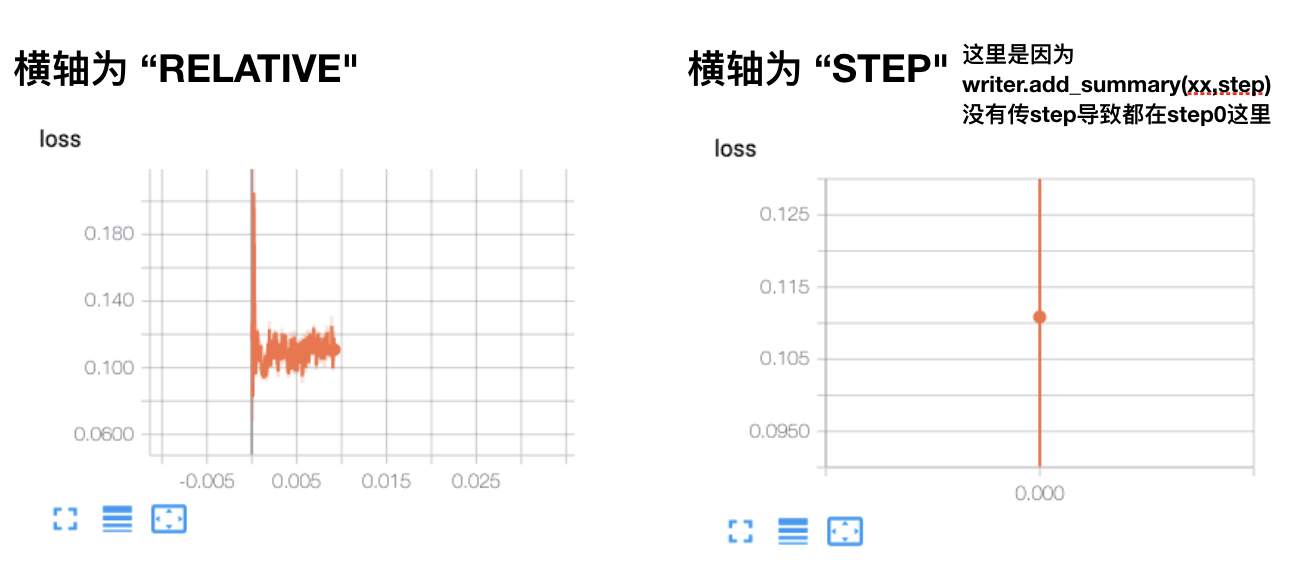


histogram
- 常用于：weight、bias、activation、gradients
- **API信息**：
```python
def histogram(name,  # 同scalar
              values,  # 任意维任意数据
              collections=None,  # 同scalar
              family=None # 同scalar
              ):
```
- 例：`tf.summary.histogram('w', w)`

```python
for i in tf.trainable_variables():
    name = i.name.split(":")[0]
    value = i.value()
    tf.summary.histogram(name, value)
```

text
- **不好用，还不如直接输出log**
- 文本生成
- **API信息:**
```python
def text(
        name, 
        tensor, 
        collections=None
        ):
```
- 例：`summary_op0 = tf.summary.text('text', tf.convert_to_tensor("Sample Text"))`

其他：
`tf.summary.audio`, `tf.summary.image`, `tf.summary.text`

## 存梯度的时候要分开存
- 如果不小心直接histogram了整个grads，会尝试merge各个变量的gradient，一般会因为rank不匹配报错，不知道merge成功是什么样的
```python
for g in grads:
    tf.summary.histogram(g.name, grads)
```

## 关于可视化LSTM的权重
- 参考 [SO的这个讨论](https://stackoverflow.com/questions/47640455/tensorboard-visualize-weights-of-lstm)
- **「注意」**: 需要在执行 `tf.nn.dynamic_rnn` 之后取 `variables` 才能拿到值，否则是空的list
    - `LSTMCell.variables`一维数组两个元素——`kernel`和`bias`
    - `MultiRNNCell.variables`一维数组2N个元素——依次是`[kernel,bias,kernel,bias]`

In [31]:
tf.reset_default_graph()
np.random.seed(10)
# batch_size:2  timesteps:4 inputs:5
# 在NLP任务可以理解为：2段语料，每个语料4个词（索引），每个词5维向量
X = np.random.randn(2,4,5).astype(np.float32)
X[1, 2:] = 0  # 指定索引位置的元素全置为0
print(">>X:{}\n".format(X.shape),X)
X_lengths = [4,2]  # 手动指定各batch里有效数据（非0数据）的步长


def make_cell(hidden_size:int, is_training:bool=True, keep_prob:float=0.8):
    cell = tf.nn.rnn_cell.LSTMCell(hidden_size, forget_bias=0.0)
    if is_training and keep_prob < 1:
        cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell
layer_num = 2
hidden_size = 3
mlstm_cell = tf.nn.rnn_cell.MultiRNNCell([make_cell(hidden_size) for _ in range(layer_num)], state_is_tuple=True)
print(f">>> 在执行之前就取 variable 是空的list:\n{mlstm_cell.variables}")
init_state = mlstm_cell.zero_state(X.shape[0], dtype=tf.float32)
outputs, last_states = tf.nn.dynamic_rnn(cell=mlstm_cell, 
                                         inputs=X, 
                                         initial_state=init_state,
                                         sequence_length=X_lengths)
print(f">>> 在执行dynamic_rnn之后获取才有用variable:\n{mlstm_cell.variables}")
for idx,tensor in enumerate(mlstm_cell.variables):
    if idx % 2 == 0:
        print(f"  ++偶数索引下为kernel:{tensor}")
        _ = tf.summary.histogram(f"lstm_kernel_{idx}",tensor)
    else:
        print(f"  --奇数索引下为bias:{tensor}")
        _ = tf.summary.histogram(f"lstm_bias_{idx}",tensor)
        
# 在sess里跑出结果看看
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    vars_ = sess.run(mlstm_cell.variables)  # 直接init还不行，还得run才有结果

    print("\n","*****在sess里跑出结果观察*****")
    for idx,tensor in enumerate(vars_):
        if idx % 2 == 0:
            print(f"  ++偶数索引下为kernel:{tensor.shape}\n",tensor)
        else:
            print(f"  --奇数索引下为bias:{tensor.shape}\n",tensor)

>>X:(2, 4, 5)
 [[[ 1.3315865   0.715279   -1.5454003  -0.00838385  0.621336  ]
  [-0.72008556  0.26551157  0.10854852  0.00429143 -0.17460021]
  [ 0.4330262   1.2030374  -0.96506566  1.028274    0.22863013]
  [ 0.44513762 -1.1366022   0.13513687  1.484537   -1.0798049 ]]

 [[-1.9777282  -1.7433723   0.26607016  2.3849673   1.1236912 ]
  [ 1.6726222   0.09914921  1.3979964  -0.27124798  0.6132042 ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]]
>>> 在执行之前就取 variable 是空的list:
[]
>>> 在执行dynamic_rnn之后获取才有用variable:
[<tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0' shape=(8, 12) dtype=float32_ref>, <tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0' shape=(12,) dtype=float32_ref>, <tf.Variable 'rnn/multi_rnn_cell/cell_1/lstm_cell/kernel:0' shape=(6, 12) dtype=float32_ref>, <tf.Variable 'rnn/multi_rnn_cell/cell_1/lstm_cell/bias:0' shape=(12,) dtype=float32_ref>]
  ++偶数索引下为kernel:<tf.Variable 'r

## Tensorboard查看模型和restore的模型
看了一个anan lstm的例子，restore之前就会先搭建计算图，具体如下：
- 构建了一个CharRNN类，实例化一个`model=CharRNN(...)`然后训练
- 模型存储ckpt
- 在新的session里
 1. 先实例化新的`model_pred=CharRNN(...,batch_size=1,num_step=1)`，
     - 除了`batch_size`和`num_step`其他参数跟训练的时候是相同的
     >`batch_size`和`num_step`作者是作为`CharRNN`的参数，在构建计算图时写死的，而不是用`placeholder`传进来的，所以，在预测阶段需要重新指定一下(这个例子是二者都重置为1)
 2. 然后再 restore ckpt，这里将参数恢复到了当前计算图里
 
**训练阶段的计算图和预测阶段的计算图对比如下：**
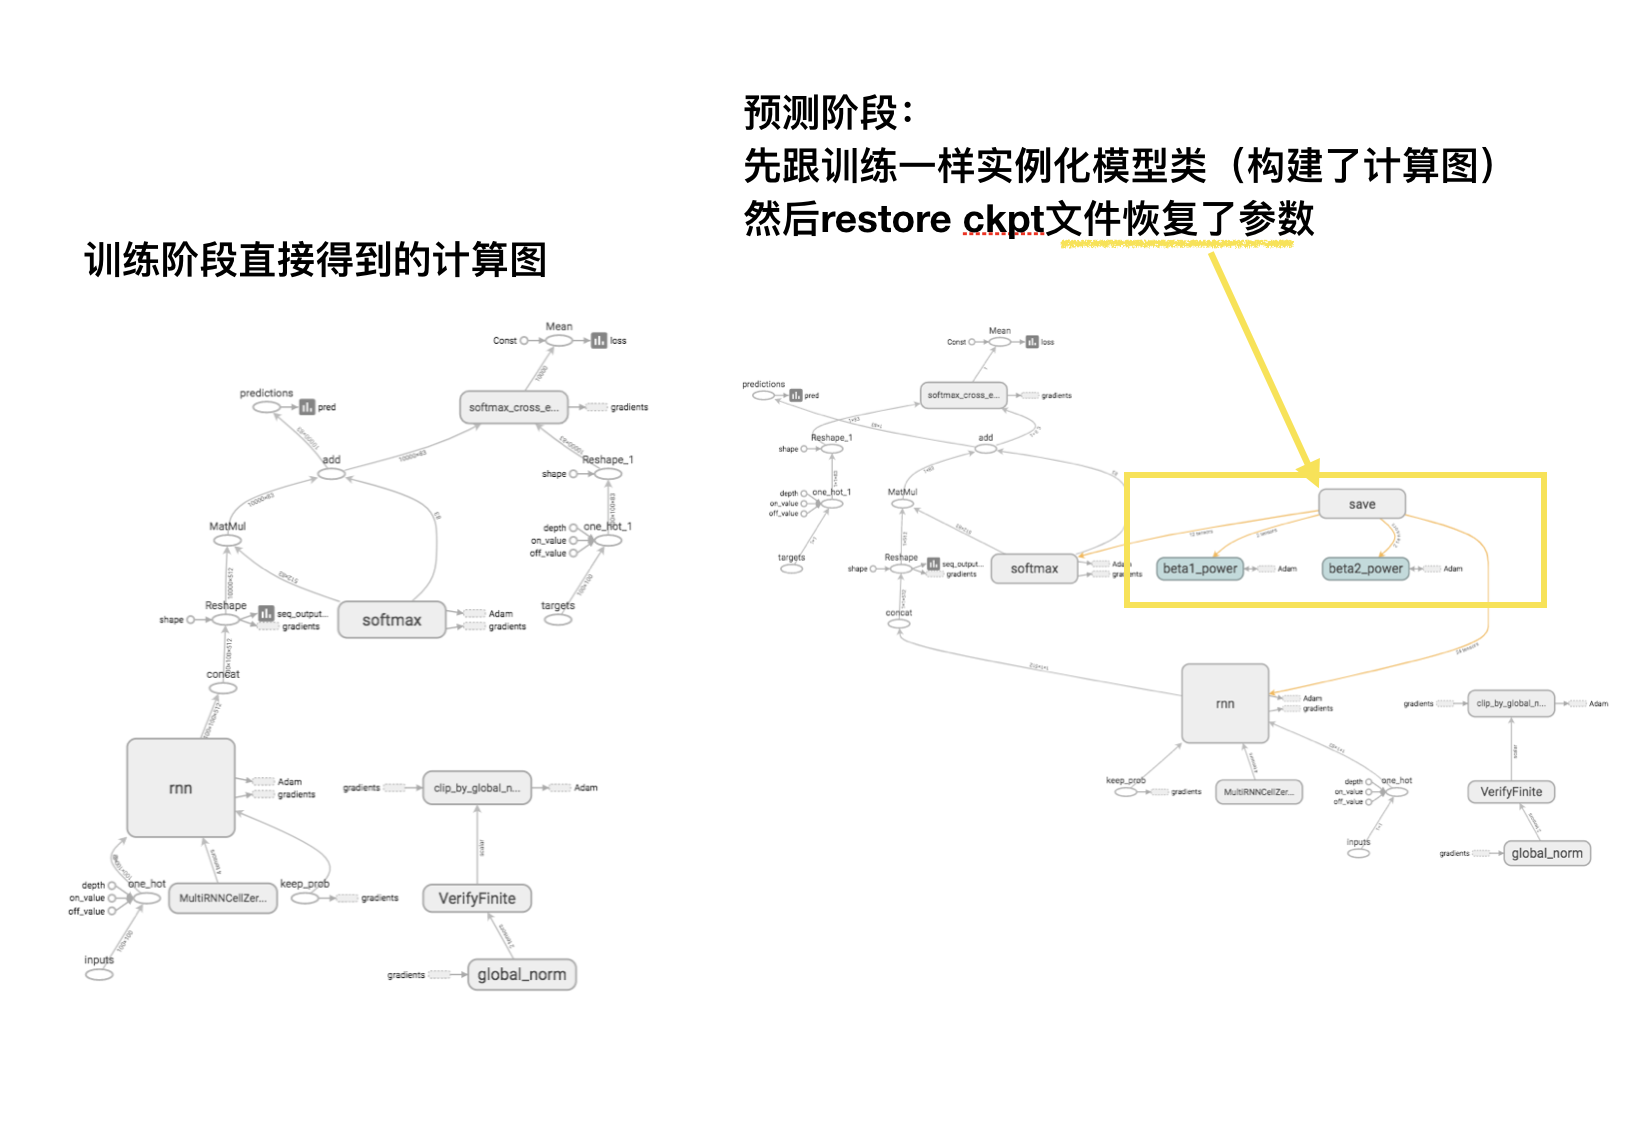

# Ordinary Operations

## tf.stop_gradient
- 参考: https://zhuanlan.zhihu.com/p/35003434
> 两个特点：
>  - this op outputs its input tensor as-is； 输出和输入的tensor一样；
>  - this op prevents the contribution of its inputs to be taken into account. 阻止输入的节点的loss计入梯度计算；
>
> .... # 一个代码实验
>
> 结论：
> - 必须使用新的被截断的节点名称去做运算才能达到截断某些路径梯度的目的
> - 在任意一个节点截断它的梯度，都会导致和它相连的前面的所有节点的梯度消失， 但是如果它前面的节点有从其他节点回传的梯度，梯度仍然会存在
> - 采用更换计算loss的方式（只计算某一个路径的loss）也可以达到和截断梯度同样的效果

要达成「不训练某个节点」的目的，类似的办法还有
- 在 `optimizer.minimize(loss, global_step, var_list=var_list)` 中，`var_list`里排除掉不训练的节点
- 直接设置`trainable`

## 从名字获取tensor或op

In [ ]:
tensor= tf.get_default_graph().get_tensor_by_name("example:0")
op = tf.get_default_graph().get_operation_by_name("enqueue")


## tf.placeholder
- 支持一维变长的数组

In [65]:
inpTS = tf.placeholder(tf.int32, [None], name="time_steps")
with tf.Session() as sess:
    sess.run(inpTS, feed_dict={inpTS:[1,2,3]})
    sess.run(inpTS, feed_dict={inpTS:[1,2,3,4,5,6]})

array([1, 2, 3], dtype=int32)

array([1, 2, 3, 4, 5, 6], dtype=int32)

## tf.einsum

In [24]:
img1 = np.array([[[1,2,3], [2,3,4], [1,2,3]],
                 [[1,2,3], [2,3,4], [1,2,3]],
                 [[1,2,3], [2,3,4], [1,2,3]],])

img2 = np.array([[[1,1,3], [2,3,4], [1,2,3]],
                 [[1,1,3], [2,3,4], [1,2,3]],
                 [[1,1,3], [2,3,4], [1,2,3]],])

# img1=np.random.random((4,3,3))
# img2=np.random.random((4,3,3))
f"img1.shape:{img1.shape}, img2.shape:{img2.shape}"
a = np.expand_dims(img1,axis=0)
b = np.expand_dims(img2,axis=0)
f"a.shape:{a.shape}, b.shape: {b.shape}"

res = np.einsum('ijkm,ijkn->imn',a,b)
f"res.shape:{res.shape}"
res

a[0,:,:,0]
b[0,:,:,0]


'img1.shape:(3, 3, 3), img2.shape:(3, 3, 3)'

'a.shape:(1, 3, 3, 3), b.shape: (1, 3, 3, 3)'

'res.shape:(1, 3, 3)'

array([[[ 18,  27,  42],
        [ 30,  45,  72],
        [ 42,  63, 102]]])

array([[1, 2, 1],
       [1, 2, 1],
       [1, 2, 1]])

array([[1, 2, 1],
       [1, 2, 1],
       [1, 2, 1]])

In [ ]:
# Matrix multiplication
>>> einsum('ij,jk->ik', m0, m1)  # output[i,k] = sum_j m0[i,j] * m1[j, k]

# Dot product
>>> einsum('i,i->', u, v)  # output = sum_i u[i]*v[i]

# Outer product
>>> einsum('i,j->ij', u, v)  # output[i,j] = u[i]*v[j]

# Transpose
>>> einsum('ij->ji', m)  # output[j,i] = m[i,j]

# Trace
>>> einsum('ii', m)  # output[j,i] = trace(m) = sum_i m[i, i]

# Batch matrix multiplication
>>> einsum('aij,ajk->aik', s, t)  # out[a,i,k] = sum_j s[a,i,j] * t[a, j, k]

## tf.add & tf.nn.bias_add
- [StackOverflow](https://stackoverflow.com/questions/43131606/whats-the-difference-of-add-methods-in-tensorflow)
>tf.add is a general addition operation, while tf.nn.bias_add is to be used specifically for adding bias to the weights, which **raises an exception if the dtypes aren't same.**
>
>Unlike **tf.add**, the **type of bias is allowed to differ from value** in the case where both types are quantized.

## 乘法类
- tf.matmul 
- tf.multiply
- tf.tensordot
- 直接用 vec1 * vec2

### tf.matmul
矩阵乘法，要求shape是 (M,N) * (N,T)

In [15]:
_a = [1,2,3]
_b = [10,0,1]
a = tf.Variable(_a,dtype=tf.float32)
b = tf.Variable(_b,dtype=tf.float32)
print("a:\n", a.numpy())
print("b:\n", b.numpy())
print(">>> tf.matmul")
A = tf.reshape(a, [3,-1])
B = tf.reshape(b, [-1,3])
print("A:\n",A)
print("B:\n",B)
print("A*B:\n", tf.matmul(A, B))
A = tf.reshape(a, [3,-1])
B = tf.reshape(b, [-1,3])
print("A:\n",A)
print("B:\n",B)
print("B*A:\n", tf.matmul(B, A))

a:
 [1. 2. 3.]
b:
 [10.  0.  1.]
>>> tf.matmul
A:
 tf.Tensor(
[[1.]
 [2.]
 [3.]], shape=(3, 1), dtype=float32)
B:
 tf.Tensor([[10.  0.  1.]], shape=(1, 3), dtype=float32)
A*B:
 tf.Tensor(
[[10.  0.  1.]
 [20.  0.  2.]
 [30.  0.  3.]], shape=(3, 3), dtype=float32)
A:
 tf.Tensor(
[[1.]
 [2.]
 [3.]], shape=(3, 1), dtype=float32)
B:
 tf.Tensor([[10.  0.  1.]], shape=(1, 3), dtype=float32)
B*A:
 tf.Tensor([[13.]], shape=(1, 1), dtype=float32)


### tf.einsum

In [64]:
A = tf.Variable(np.random.random([1,2,3]))
B = tf.Variable(np.random.random([1,3,2]))

print("A:\n",A)
print("B:\n",B)
print("B*A:\n", tf.matmul(B, A))
print("tf.einsum:\n",tf.einsum("bik,bkj->bij", B, A))
print("B*A第一个元素的拆解:\n",sum(B[0,0] * A[:,:,0][0]))

A:
 <tf.Variable 'Variable:0' shape=(1, 2, 3) dtype=float64, numpy=
array([[[0.6197078 , 0.79785399, 0.52082982],
        [0.40636167, 0.66223146, 0.33740885]]])>
B:
 <tf.Variable 'Variable:0' shape=(1, 3, 2) dtype=float64, numpy=
array([[[0.86673312, 0.49676738],
        [0.19349588, 0.56958831],
        [0.69776768, 0.25406117]]])>
B*A:
 tf.Tensor(
[[[0.7389885  1.02050147 0.61903416]
  [0.35136977 0.53158076 0.29296256]
  [0.5356528  0.72496403 0.4491407 ]]], shape=(1, 3, 3), dtype=float64)
tf.einsum:
 tf.Tensor(
[[[0.7389885  1.02050147 0.61903416]
  [0.35136977 0.53158076 0.29296256]
  [0.5356528  0.72496403 0.4491407 ]]], shape=(1, 3, 3), dtype=float64)
B*A第一个元素的拆解:
 tf.Tensor(0.7389885017577997, shape=(), dtype=float64)


### tf.multiply
element-wise / 点乘但是没有sum

In [19]:
_a = [[1,2,3],[4,5,6]]
_b = [[10,0,1],[0,0,1]]
a = tf.Variable(_a,dtype=tf.float32)
b = tf.Variable(_b,dtype=tf.float32)
print("a:\n", a.numpy())
print("b:\n", b.numpy())
print(">>> tf.multiply")
print("a*b:\n",tf.multiply(a,b))

a:
 [[1. 2. 3.]
 [4. 5. 6.]]
b:
 [[10.  0.  1.]
 [ 0.  0.  1.]]
>>> tf.multiply
a*b:
 tf.Tensor(
[[10.  0.  3.]
 [ 0.  0.  6.]], shape=(2, 3), dtype=float32)


### 直接乘 | a*b

In [38]:
_a = [[1,2,3],[4,5,6]]
_b = [[10,0,1],[0,0,1]]
a = tf.Variable(_a,dtype=tf.float32)
b = tf.Variable(_b,dtype=tf.float32)
print("a:\n", a.numpy())
print("b:\n", b.numpy())
print(">>> directly multiply")
print("a*b:\n",a*b)
tf.reduce_sum(a*b, axis=1)

a:
 [[1. 2. 3.]
 [4. 5. 6.]]
b:
 [[10.  0.  1.]
 [ 0.  0.  1.]]
>>> directly multiply
a*b:
 tf.Tensor(
[[10.  0.  3.]
 [ 0.  0.  6.]], shape=(2, 3), dtype=float32)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([13.,  6.], dtype=float32)>

### tf.tensordot

In [33]:
_a = [[1,2,3],[4,5,6]]
_b = [[10,0,1],[0,0,1]]
a = tf.Variable(_a,dtype=tf.float32)
b = tf.Variable(_b,dtype=tf.float32)
print("a:%s \n" % a.shape, a.numpy())
print("b:%s \n" % b.shape, b.numpy())
print(">>> tf.tensordot")
print("a*b axes=0: %s \n" % tf.tensordot(a,b,axes=0).shape, tf.tensordot(a,b,axes=0))
print("a[0]:%s \n" % a[0].shape, a[0].numpy())
print("a[0]*b axes=0: %s \n" % tf.tensordot(a[0],b,axes=0).shape, tf.tensordot(a[0],b,axes=0))
# print("a*b axes=1:\n",tf.tensordot(a,b,axes=1))
print("a*b axes=1:\n","InvalidArgumentError: Matrix size-incompatible: In[0]: [2,3], In[1]: [2,3] [Op:MatMul]")

a:(2, 3) 
 [[1. 2. 3.]
 [4. 5. 6.]]
b:(2, 3) 
 [[10.  0.  1.]
 [ 0.  0.  1.]]
>>> tf.tensordot
a*b axes=0: (2, 3, 2, 3) 
 tf.Tensor(
[[[[10.  0.  1.]
   [ 0.  0.  1.]]

  [[20.  0.  2.]
   [ 0.  0.  2.]]

  [[30.  0.  3.]
   [ 0.  0.  3.]]]


 [[[40.  0.  4.]
   [ 0.  0.  4.]]

  [[50.  0.  5.]
   [ 0.  0.  5.]]

  [[60.  0.  6.]
   [ 0.  0.  6.]]]], shape=(2, 3, 2, 3), dtype=float32)
a[0]:(3,) 
 [1. 2. 3.]
a[0]*b axes=0: (3, 2, 3) 
 tf.Tensor(
[[[10.  0.  1.]
  [ 0.  0.  1.]]

 [[20.  0.  2.]
  [ 0.  0.  2.]]

 [[30.  0.  3.]
  [ 0.  0.  3.]]], shape=(3, 2, 3), dtype=float32)
a*b axes=1:
 InvalidArgumentError: Matrix size-incompatible: In[0]: [2,3], In[1]: [2,3] [Op:MatMul]


## tf.expand_dims & tf.reshape

In [62]:
a_ = [[[1,1],[2,2]],
      [[3,3],[4,4]]]
a_ = np.array(a_)
"a_",a_.shape

a = tf.Variable(a_,dtype=tf.float32)
"a",a.shape

a_tfreshape = tf.reshape(a,[2,2,2,-1])
"a_tfreshape",a_tfreshape.shape
a_tfexpand = tf.expand_dims(a,-1)
"a_tfexpand",a_tfexpand.shape

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("原始shape为")
    sess.run(tf.shape(a))
    print("-1 就是在最后一维上扩展一个")
    sess.run(tf.shape(tf.expand_dims(a,-1)))
    print("0 就是在第0维上扩展一个")
    sess.run(tf.shape(tf.expand_dims(a,0)))
    print("1 就是在第1维上扩展一个")
    sess.run(tf.shape(tf.expand_dims(a,1)))

('a_', (2, 2, 2))

('a', TensorShape([Dimension(2), Dimension(2), Dimension(2)]))

('a_tfreshape',
 TensorShape([Dimension(2), Dimension(2), Dimension(2), Dimension(1)]))

('a_tfexpand',
 TensorShape([Dimension(2), Dimension(2), Dimension(2), Dimension(1)]))

原始shape为


array([2, 2, 2], dtype=int32)

-1 就是在最后一维上扩展一个


array([2, 2, 2, 1], dtype=int32)

0 就是在第0维上扩展一个


array([1, 2, 2, 2], dtype=int32)

1 就是在第1维上扩展一个


array([2, 1, 2, 2], dtype=int32)

## tf.reshape

In [68]:
a = np.random.randint(10,size=[2,3,8])
a_reshape = tf.reshape(a,[6,8])
a_reshape_strange = tf.reshape(a,[2,24])
with tf.Session() as sess:
    a_reshape_,a_reshape_strange_ = sess.run([a_reshape,a_reshape_strange])
    print("a: {}\n".format(a.shape),a)
    print("a_reshape_: {}\n".format(a_reshape_.shape),a_reshape_)
    print("a_reshape_strange_: {}\n".format(a_reshape_strange_.shape),a_reshape_strange_)

a: (2, 3, 8)
 [[[4 7 6 3 8 8 5 6]
  [1 7 9 2 3 3 8 7]
  [4 3 8 2 8 6 5 1]]

 [[3 4 1 7 0 8 5 3]
  [1 2 2 8 9 1 1 9]
  [7 2 8 8 8 8 5 2]]]
a_reshape_: (6, 8)
 [[4 7 6 3 8 8 5 6]
 [1 7 9 2 3 3 8 7]
 [4 3 8 2 8 6 5 1]
 [3 4 1 7 0 8 5 3]
 [1 2 2 8 9 1 1 9]
 [7 2 8 8 8 8 5 2]]
a_reshape_strange_: (2, 24)
 [[4 7 6 3 8 8 5 6 1 7 9 2 3 3 8 7 4 3 8 2 8 6 5 1]
 [3 4 1 7 0 8 5 3 1 2 2 8 9 1 1 9 7 2 8 8 8 8 5 2]]


## tf.concat
- 维度变化：concat,axis=1: (2,3,6)+(2,4,6) => (2,7,6)

In [70]:
a = np.random.randint(10,size=[1,3,6])
b = np.random.randint(10,size=[1,4,6])
print("a: {}\n".format(a.shape),a)
print("b: {}\n".format(b.shape),b)
print("a,b 除了要concat的维度，其他维度必须一样才行")
c = tf.concat([a,b],axis=1)
with tf.Session() as sess:
    c_res = sess.run(c)
    print("c: {}\n".format(c_res.shape),c_res)

a: (1, 3, 6)
 [[[1 8 6 4 8 8]
  [2 5 1 8 3 5]
  [6 4 8 7 3 1]]]
b: (1, 4, 6)
 [[[1 4 7 4 5 7]
  [2 7 6 6 8 0]
  [5 7 6 5 7 3]
  [6 1 9 0 5 9]]]
a,b 除了要concat的维度，其他维度必须一样才行
c: (1, 7, 6)
 [[[1 8 6 4 8 8]
  [2 5 1 8 3 5]
  [6 4 8 7 3 1]
  [1 4 7 4 5 7]
  [2 7 6 6 8 0]
  [5 7 6 5 7 3]
  [6 1 9 0 5 9]]]


In [107]:
lstm_size = 6
a = np.array([[[i]*lstm_size for i in range(3)] for _ in range(2)])
a_1 = a[:,:1,:]
a_2 = a[:,1:,:]
print(f">>> a:{a.shape}\n",a)
print(f">>> a的上半部分a_1: [shape]:{a_1.shape}\n",a_1)
print(f">>> a的下半部分a_2: [shape]:{a_2.shape}\n",a_2)

with tf.Session() as sess:
    a_tfconcat = sess.run(tf.concat(a,axis=1))
    print(f">>> tf.concat(a,axis=1): [shape]:{a_tfconcat.shape}\n",a_tfconcat)
    a_tfreshape = sess.run(tf.reshape(a,[-1,lstm_size]))
    print(f">>> tf.reshape(a,[-1,lstm_size]): [shape]:{a_tfreshape.shape}\n",a_tfreshape)
    a_concat2part = sess.run(tf.concat([a_1,a_2], axis=1))
    print(f">>> tf.concat([a_1,a_2],axis=1): [shape]:{a_concat2part.shape}\n",a_concat2part)

    print(f">>> concat参数传一个tensor是不会发生任何变化的, tf.concat(a,axis=1)==a: {(a_tfconcat==a).all()}")
    print(f">>> 把这个tensor拆成两部分再来concat得到原变量, （然后在做reshape）")
    print(f">>>   tf.concat([a_1,a_2],axis=1)==a:{(a_concat2part==a).all()}")
    
    a_np_concatenate = np.concatenate(a,axis=1)
    print(f"numpy的concatenate是可以做到对一个多维数组在某一维度做concate的:shape变化是{a.shape}==>{a_np_concatenate.shape}\n",a_np_concatenate)

>>> a:(2, 3, 6)
 [[[0 0 0 0 0 0]
  [1 1 1 1 1 1]
  [2 2 2 2 2 2]]

 [[0 0 0 0 0 0]
  [1 1 1 1 1 1]
  [2 2 2 2 2 2]]]
>>> a的上半部分a_1: [shape]:(2, 1, 6)
 [[[0 0 0 0 0 0]]

 [[0 0 0 0 0 0]]]
>>> a的下半部分a_2: [shape]:(2, 2, 6)
 [[[1 1 1 1 1 1]
  [2 2 2 2 2 2]]

 [[1 1 1 1 1 1]
  [2 2 2 2 2 2]]]
>>> tf.concat(a,axis=1): [shape]:(2, 3, 6)
 [[[0 0 0 0 0 0]
  [1 1 1 1 1 1]
  [2 2 2 2 2 2]]

 [[0 0 0 0 0 0]
  [1 1 1 1 1 1]
  [2 2 2 2 2 2]]]
>>> tf.reshape(a,[-1,lstm_size]): [shape]:(6, 6)
 [[0 0 0 0 0 0]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]]
>>> tf.concat([a_1,a_2],axis=1): [shape]:(2, 3, 6)
 [[[0 0 0 0 0 0]
  [1 1 1 1 1 1]
  [2 2 2 2 2 2]]

 [[0 0 0 0 0 0]
  [1 1 1 1 1 1]
  [2 2 2 2 2 2]]]
>>> concat参数传一个tensor是不会发生任何变化的, tf.concat(a,axis=1)==a: True
>>> 把这个tensor拆成两部分再来concat得到原变量, （然后在做reshape）
>>>   tf.concat([a_1,a_2],axis=1)==a:True
numpy的concatenate是可以做到对一个多维数组在某一维度做concate的:shape变化是(2, 3, 6)==>(3, 12)
 [[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1

## tf.stack
- 维度变化: stack,axis=1 (2,3,6)+(2,3,6) => (2,2,3,6)
- stack要求两个tensor**维度必须是相同的**，本来是 $[D_1,D_2,..D_n]$ 的共n个维度的俩tensor，stack后变成n+1个维度，多+1的那个维度为`2`，具体这个+1的维度`2`放在哪就由`axis=`决定，`axis=0`那这个`2`就放在索引0上

shape为(3,4,5)的两个tensor在不同axis上做stack
- axis=0: (**2**,3,4,5)
- axis=1: (3,**2**,4,5)
- axis=2: (3,4,**2**,5)
- axis=3: (3,4,5,**2**)

stack三个维度相同的tensor那就是把`3`添加在`axis`指定的索引位置上

In [49]:
a = np.random.random([3,4,5])
b = np.random.random([3,4,5])
e = np.random.random([3,4,5])
c = tf.stack([a,b,e], axis=3)
a.shape
b.shape
c.shape

(3, 4, 5)

(3, 4, 5)

TensorShape([Dimension(3), Dimension(4), Dimension(5), Dimension(3)])

## tf.unstack
按`axis`指定的维度拆开，该维度取值是多少就拆成多少个tensor

shape为(3,4,5,2)的一个tensor在不同axis上做unstack
- axis=0: [(4,5,2)]*3
- axis=1: [(3,5,2)]*4
- axis=2: [(3,4,2)]*5
- axis=3: [(3,4,5)]*2

In [57]:
m = np.random.random([3,4,5,2])
m.shape
tf.unstack(m)
tf.unstack(m,axis=0)
tf.unstack(m,axis=1)
tf.unstack(m,axis=2)
tf.unstack(m,axis=3)

# ?tf.unstack

(3, 4, 5, 2)

[<tf.Tensor 'unstack_10:0' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_10:1' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_10:2' shape=(4, 5, 2) dtype=float64>]

[<tf.Tensor 'unstack_11:0' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_11:1' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_11:2' shape=(4, 5, 2) dtype=float64>]

[<tf.Tensor 'unstack_12:0' shape=(3, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_12:1' shape=(3, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_12:2' shape=(3, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_12:3' shape=(3, 5, 2) dtype=float64>]

[<tf.Tensor 'unstack_13:0' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:1' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:2' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:3' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:4' shape=(3, 4, 2) dtype=float64>]

[<tf.Tensor 'unstack_14:0' shape=(3, 4, 5) dtype=float64>,
 <tf.Tensor 'unstack_14:1' shape=(3, 4, 5) dtype=float64>]

## tf.reduce_mean
tf.reduce_mean, reduce_sum, reduce_max就是计算某一个维度上的均值、加和、最值
>tf.reduce_mean(input_tensor, axis=None, keepdims=None, name=None, reduction_indices=None, keep_dims=None)
- axis：
    - axis=None, 求全部元素的平均值；
    - axis=0, 列平均值；
    - axis=1，行平均值。 
- keep_dims：若值为True，可多行输出平均值。 
- name：自定义操作名。 
- ~~reduction_indices：axis的旧名，已停用。~~

In [146]:
np.random.seed(2019)
a = np.random.randint(0,10,size=[2,3])
print(">>> a: {}\n".format(a.shape),a)
a_var = tf.Variable(a)

sum_on_none = tf.reduce_sum(a,axis=None)
sum_on_0 = tf.reduce_sum(a,axis=0)
mean_on_none = tf.reduce_mean(a,axis=None)
mean_on_0 = tf.reduce_mean(a,axis=0)
with tf.Session() as sess:
    sum_res_none, sum_res_0, res_none, res_0 = sess.run([sum_on_none, sum_on_0,mean_on_none,mean_on_0])
    print(">>> axis=None 上做reduce_sum: {}\n".format(sum_res_none.shape), sum_res_none)
    print(">>> axis=0 上做reduce_sum: {}\n".format(sum_res_0.shape), sum_res_0)
    print(">>> axis=None 上做reduce_mean: {}\n".format(res_none.shape), res_none)
    print(">>> axis=0 上做reduce_mean: {}\n".format(res_0.shape), res_0)

>>> a: (2, 3)
 [[8 2 5]
 [8 6 8]]
>>> b: (10,)
 [0 0 7 8 5 3 0 2 5 7]
>>> axis=None 上做reduce_sum: ()
 37
>>> axis=0 上做reduce_sum: (3,)
 [16  8 13]
>>> axis=None 上做reduce_mean: ()
 6
>>> axis=0 上做reduce_mean: (3,)
 [8 4 6]


### 测试在一维数组上做tf.reduce_mean

In [147]:
a = np.random.randint(0,10,size=[10])
print(">>> a: {}\n".format(a.shape),a)
sum_on_none = tf.reduce_sum(a,axis=None)
sum_on_0 = tf.reduce_sum(a,axis=0)
mean_on_none = tf.reduce_mean(a,axis=None)
mean_on_0 = tf.reduce_mean(a,axis=0)
with tf.Session() as sess:
    sum_res_none, sum_res_0, res_none, res_0 = sess.run([sum_on_none, sum_on_0,mean_on_none,mean_on_0])
    print(">>> axis=None 上做reduce_sum: {}\n".format(sum_res_none.shape), sum_res_none)
    print(">>> axis=0 上做reduce_sum: {}\n".format(sum_res_0.shape), sum_res_0)
    print(">>> axis=None 上做reduce_mean: {}\n".format(res_none.shape), res_none)
    print(">>> axis=0 上做reduce_mean: {}\n".format(res_0.shape), res_0)

>>> a: (10,)
 [8 5 4 0 1 6 0 2 6 6]
>>> axis=None 上做reduce_sum: ()
 38
>>> axis=0 上做reduce_sum: ()
 38
>>> axis=None 上做reduce_mean: ()
 3
>>> axis=0 上做reduce_mean: ()
 3


## tf.transpose
> tf.transpose(a, perm=None, name='transpose', conjugate=False)
- a 需要转置的tensor
- perm （permute）转置的形式
    - `None` 表示把shape倒转过来，如[3,4]变成[4,3]，[1,2,3,4]变成[4,3,2,1]
    - `list[int]类型` 里面的int表示原始维度的索引按list里的顺序来排列
        - 如`[0,3,2,1]`表示原始的维度`3`放到第二个,`1`放到第四个（二、四维互换了）
        - 如`[1,3,2,0]`表示转置后的，按数字作为索引把原始的维度按当前list里的顺序重新排列

In [23]:
a = np.random.random([3,4,5,6])
a.shape
tf.transpose(a)
tf.transpose(a,[2,1,0,3])

(3, 4, 5, 6)

<tf.Tensor 'transpose_8:0' shape=(6, 5, 4, 3) dtype=float64>

<tf.Tensor 'transpose_9:0' shape=(5, 4, 3, 6) dtype=float64>

## tf.truncated_normal
按指定均值、标准差生成正态分布的数据，并且做两倍标准差截断
> tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None) :
- shape表示生成张量的维度
- mean是均值 | 默认为0
- stddev是标准差。 | 默认为1.0
- seed随机数种子
>
>这个函数产生正太分布，均值和标准差自己设定。这是一个截断的产生正太分布的函数，就是说产生正太分布的值如果与均值的差值大于两倍的标准差，那就重新生成。和一般的正太分布的产生随机数据比起来，这个函数产生的随机数与均值的差距不会超过两倍的标准差，但是一般的别的函数是可能的。

tf里的随机数种子，可以设置到图级别也可以设置为op级别
- 图级别：
```
# at some graph
tf.set_random_seed(2019)
tf.truncated_normal([3,4],stddev=0.1)
```
- op级别：
```
tf.truncated_normal([3,4],stddev=0.1,seed=2019)
```

类似的随机函数还有 `tf.random_uniform([3,4], -1, 1)` 生成-1到1的均匀分布的随机数
>tf.random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)

In [36]:
# truncated_normal 按正态分布生成数据，并且做标准差截断
with tf.Session() as sess:
    random_op = tf.truncated_normal([3,4],stddev=0.1,seed=2019)
    # random_op在一段程序里跑了三次，seed只控制程序每次相同位置生成时结果是一样的，而这三次则都不一样
    sess.run(random_op)
    sess.run(tf.cast(random_op,tf.int32))
    sess.run(tf.to_float(random_op,tf.int32))

array([[-0.01135067,  0.05639387, -0.04778707,  0.04571497],
       [ 0.1153388 ,  0.07203745,  0.15631334, -0.16913354],
       [ 0.124575  , -0.04655875,  0.0504917 ,  0.06605241]],
      dtype=float32)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

array([[ 0.04278614,  0.16716555, -0.01701541, -0.00202826],
       [ 0.11125483,  0.07280847, -0.07696502, -0.1261591 ],
       [-0.01496598, -0.01382563, -0.05033821, -0.02851957]],
      dtype=float32)

## tf.while_loop

In [17]:
i  = 0
n =10 

def cond(i, n):
    return i < n

def body(i, n):
    i = i + 1
    return i, n
i, n = tf.while_loop(cond, body, [i, n])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run([i,n])

[10, 10]

## tf.squeeze
>axis默认为None,返回一个将原始input中所有维度为1的维删掉后的tensor
>
>axis若被指定为某个维度，必须保证此维度为1，否则报错`InvalidArgumentError`
>
>`InvalidArgumentError: Can not squeeze dim[0], expected a dimension of 1, got 3 for 'Squeeze_24' (op: 'Squeeze') with input shapes: [3,1,65].`

In [117]:
# tf1.12
tf.reset_default_graph()
a = tf.Variable([[1,2,3]])
a_s = tf.squeeze(a)
a.shape
a_s.shape
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    a.eval()
    a_s.eval()

TensorShape([Dimension(1), Dimension(3)])

TensorShape([Dimension(3)])

array([[1, 2, 3]], dtype=int32)

array([1, 2, 3], dtype=int32)

## tf.split
> 切分tensor，**返回一个list**
```python
split(
    value,                 # 待切分tensor
    num_or_size_splits,    # 若是整数n，将分为n个子tensor。若是list，切分为len(list)个子tensor。 
    axis=0,                
    num=None,
    name='split'
)
```

In [103]:
import tensorflow as tf

a = np.array([[1,2,3],
     [4,5,6]])
with tf.Session() as sess:
    p=sess.run(tf.split(a, 3, 1))
    q=sess.run(tf.split(a, [1, 2], 1))
    g=sess.run(tf.split(a, [2, 1], 1))
    print(f"在axis=1上切成三份: 切分后各tensor的shape: {[i.shape for i in p]}\n>>",p)
    print(f"在axis=1上用list[1,2]切分: {[i.shape for i in q]}\n>>",q[0],"\n>>",q[1])
    print(f"在axis=1上用list[2,1]切分: {[i.shape for i in g]}\n>>",g[0],"\n>>",g[1])

在axis=1上切成三份: 切分后各tensor的shape: [(2, 1), (2, 1), (2, 1)]
>> [array([[1],
       [4]]), array([[2],
       [5]]), array([[3],
       [6]])]
在axis=1上用list[1,2]切分: [(2, 1), (2, 2)]
>> [[1]
 [4]] 
>> [[2 3]
 [5 6]]
在axis=1上用list[2,1]切分: [(2, 2), (2, 1)]
>> [[1 2]
 [4 5]] 
>> [[3]
 [6]]


## tf.slice & tf.gather
- `tf.slice`: 按照指定的下标范围抽取连续区域的子集
    - 用得少，一般直接用索引 `[a:b,c:d,:-5]` 这种方式直接取（更pythonic）
- `tf.gather`: 按照指定的下标集合从axis=0中抽取子集，适合抽取不连续区域的子集

### tf.slice
> Note that tf.Tensor.getitem is typically a more pythonic way to perform slices, as it allows you to write foo[3:7, :-2] instead of tf.slice(foo, [3, 0], [4, foo.get_shape()[1]-2]).

即`tf.slice(tensor,[3,0],[4,tensor.get_shape()[1]-2])`等价于`tensor[3:7,-2]`


### tf.gather
```python
tf.gather(
    params,
    indices,
    validate_indices=None,
    name=None,
    axis=None,
    batch_dims=0
)
```

In [42]:
# gather 就是在shape的第0维按提供的索引（list）取元素
m = [[1.,2.,3.],[4.,5.,6.]]
m_reduce = tf.reduce_mean(m, axis=0)
m_reduce0 = tf.gather(m_reduce,[0])
m_reduce2 = tf.gather(m_reduce,[2])
with tf.Session() as sess:
    m_reduce.eval()
    m_reduce0.eval()
    m_reduce2.eval()

array([2.5, 3.5, 4.5], dtype=float32)

array([2.5], dtype=float32)

array([4.5], dtype=float32)

In [29]:
vec = np.array([[[1, 1, 1], [2, 2, 2]],
                  [[3, 3, 3], [4, 4, 4]],
                  [[5, 5, 5], [6, 6, 6]]])
vec.shape
print("如下两个是一样的，因为第三维总共就三个元素，取0:3就是所有的都取了")
vec[1:2,0:1]
vec[1:2,0:1,0:3]
vec(">>> sess res as follow:")
with tf.Session() as sess:
    sess.run(tf.slice(vec, [1, 0, 0], [1, 1, 3])) # 等价于 input[1:2,0:1,0:3]
    # [[[3, 3, 3]]]

    sess.run(tf.gatherb(vec, [0, 2])) # 取 第0个 和 第2个
    # 
    # [[[1, 1, 1], [2, 2, 2]],
    #  [[5, 5, 5], [6, 6, 6]]]

(3, 2, 3)

如下两个是一样的，因为第三维总共就三个元素，取0:3就是所有的都取了


array([[[3, 3, 3]]])

array([[[3, 3, 3]]])

>>> sess res as follow:


array([[[3, 3, 3]]])

array([[[1, 1, 1],
        [2, 2, 2]],

       [[5, 5, 5],
        [6, 6, 6]]])

### tf.gather_nd
```
tf.gather_nd(
    params, indices, batch_dims=0, name=None
)
```

In [1]:
vec = np.array([[[1, 1, 1], [2, 2, 2]],
                  [[3, 3, 3], [4, 4, 4]],
                  [[5, 5, 5], [6, 6, 6]]])
with tf.Session() as sess:
    sess.run(tf.gather_nd(vec,[[0,0]]))

NameError: name 'tf' is not defined

### tf.sparse.slice
类似`tf.slice`
``` 
tf.sparse.slice(
    sp_input, start, size, name=None
)
```
- `start` 表示从这个`sp_input`的shape对应维度的索引几开始取
- `size`  表示从`start`那个索引开始取多少个元素
- 例如 `start=[3,1]` 表示`shape[0]`从`索引3`开始取，`shap[1]`从`索引1`开始取
  - `start[i]`这个元素就表示`shape[i]`这一维从`start[i]`这个元素开始取
  - `size[j]`表示`shape[j]`这一维要取`size[j]`个
  - 即start、shape、size里面的元素都是一一对应的，start的第i个元素表示sp_input的第i维该从哪里开始取

In [ ]:
sp = tf.sparse.SparseTensor([[0,0],[0,1],[1,0],[1,2],[2,0],[2,2]],[1,2,4,6,7,9],[3,3])
sp_s = tf.sparse.slice(sp,[0,1],[2,2])
with tf.Session() as sess:
    sess.run(tf.sparse.to_dense(sp,default_value=-1))
    sess.run(tf.sparse.to_dense(sp_s,default_value=-1))

# 
# array([[ 1,  2, -1],
#        [ 4, -1,  6],
#        [ 7, -1,  9]], dtype=int32)
# tf.sparse.slice(sp,[0,1],[2,2]) 取的结果如下
# array([[ 2, -1],
#        [-1,  6]], dtype=int32)
# tf.sparse.slice(sp,[1,1],[2,2]) 取的结果如下
# array([[-1,  6],
#        [-1,  9]], dtype=int32)

## tf.cast
类型转换

In [11]:
wordEmbedding = np.array([[0.8,0.9,0.6,0.5],[0.1,0.2,0.3,0.4]])
wordEmbedding
tensor = tf.cast(wordEmbedding,dtype=tf.float32,name='word2vec')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tensor)

array([[0.8, 0.9, 0.6, 0.5],
       [0.1, 0.2, 0.3, 0.4]])

array([[0.8, 0.9, 0.6, 0.5],
       [0.1, 0.2, 0.3, 0.4]], dtype=float32)

## tf.argmax & tf.nn.softmax


In [106]:
a = [1,2,3,4]
a = [float(i) for i in a]
with tf.Session() as sess:
    tf.argmax(a).eval()
    tf.nn.softmax(a).eval()

3

array([0.0320586 , 0.08714432, 0.23688284, 0.6439143 ], dtype=float32)

In [173]:
sigmoid(1)
sigmoid(0)

0.7310585786300049

0.5

## tf.random.categorical
是加权随机抽样的方法，注意权重参数要带log，因为内部实现的时候缝进去了一个softmax操作

为了使用这个函数你外部就不得不加个log，这样算softmax的时候，就变成了 
$$\frac{e^{ln(a)}}{e^{ln(a)}+e^{ln(b)+e^{ln(c)}+e^{ln(d)}}}= \frac{a}{a+b+c+d}$$
- 第一个参数是取了log的权重，注意**【必须是二维】**
    - 二维的含义是 (a,b) 会生成a组样本，每组按b代表的权重抽样n_samples个
- 注意这里面为负数的自然就被算成概率0了

In [93]:
# opt = tf.random.categorical([0.7,0.2,0.1],[3,2,4])
weights = [[0.1, 7., 17., 66.],
           [0.1, -1, 17., 66.]]  # 量级没关系，大小对就行，这个是定义了一个分布，注意必须是二维的
n_samples = 1  # 从分布中抽取 100 个样本
samples = tf.random.categorical(tf.log(weights), n_samples)
g_sess.run(samples).shape
g_sess.run(samples)
np.unique(g_sess.run(samples),return_counts=True)

(2, 1)

array([[2],
       [3]])

(array([2, 3]), array([1, 1]))

## tf.onehot
**API参数信息**
```python
tf.one_hot(
    indices,
    depth,
    on_value=None,
    off_value=None,
    axis=None,
    dtype=None,
    name=None
)
```
- 为索引`-1`保留了 `[0]*depth`的编码，索引`0`是从`[1,0,0...]`开始
    - 其他负数索引都为`[0]*depth`

`depth` 总数量 | 可以提供小于真实总数的值，逻辑是直接截断，`max(indices)+1`可以生效，但是如果再小的话max的数就被截断成0了

`indices` 即特征向量的`[32,104,22,33]`或者特征矩阵`[[22,11,44],[8,19],[88,33]]`

`on_value` 默认是 `1`, `off_value` 默认是 `0`

`axis`: 
> If the input indices is rank N, the output will have rank N+1. The new axis is created at dimension axis (default: the new axis is appended at the end).
- 当`indices`是特征**向量**时,`output_shape`:
```python
features x depth if axis == -1
depth x features if axis == 0
```
- 当`indices`是特征**矩阵**时,`output_shape`:
```python
batch x features x depth if axis == -1
batch x depth x features if axis == 1
depth x batch x features if axis == 0
```



In [13]:
indices = [-1,0,3,5,7]
depth = 8
with tf.Session() as sess:
    print(sess.run(tf.one_hot(indices,depth)))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


## loss相关

### 交叉熵
- tf计算CE的一些方法在第三部分"NN relevants"有详细实验
```python
# L2正则
l2Loss = tf.constant(0.0)
l2Loss += tf.nn.l2_loss(outputW)
l2Loss += tf.nn.l2_loss(outputB)
# CE
loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.inputY)
self.loss = tf.reduce_mean(losses) + config.model.l2RegLambda * l2Loss
```

### logloss
- 摘自对DeepFM的复现
```python
empirical_risk = tf.reduce_mean(tf.losses.log_loss(label, pred))
if self.l2_reg>0:  # 使用L2正则
    structural_risk = tf.contrib.layers.l2_regularizer(self.l2_reg)(weights["concat_projection"])
    structural_risk += tf.contrib.layers.l2_regularizer(self.l2_reg)(weights["feature_embeddings"])
    structural_risk += tf.contrib.layers.l2_regularizer(self.l2_reg)(weights["feature_bias"])
    for i in range(len(self.deep_layers)):
        structural_risk += tf.contrib.layers.l2_regularizer(self.l2_reg)(weights["layer_%d"%i])
    tf.summary.scalar('structural_risk_L2',structural_risk)
    loss_op = empirical_risk + structural_risk
```

### MSE
```python
self.loss = tf.nn.l2_loss(tf.subtract(self.label, self.out))
```

## gradient相关

### tf.GradientTape()
**可训练的不用管，直接被watch了；其他的可以手动watch一下**
> Trainable variables (created by tf.Variable or tf.compat.v1.get_variable, where trainable=True is default in both cases) are automatically watched. Tensors can be manually watched by invoking the watch method on this context manager.


直接计算梯度
```python
x = tf.constant(3.0)
with tf.GradientTape() as g:
    g.watch(x)
    y = x * x
dy_dx = g.gradient(y, x) # Will compute to 6.0
```

求高阶导
```python
x = tf.constant(3.0)
with tf.GradientTape() as g:
    with tf.GradientTape() as gg:
        gg.watch(x)
        y = x * x
    dy_dx = gg.gradient(y, x)   # 对x求一阶导 Will compute to 6.0
d2y_dx2 = g.gradient(dy_dx, x)  # 对x求二阶导 Will compute to 2.0
```

如果在`with`之后会用到多次`g`，需要在`with`初始化时指定`persistent=True`，后面可以`del g`手动清除
```python
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as g:
    g.watch(x)
    y = x * x
    z = y * y
dz_dx = g.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
dy_dx = g.gradient(y, x)  # 6.0
del g  # Drop the reference to the tape
```

### opt -> opt.compute -> opt.apply
```python
_optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999,epsilon=1e-8)
grad = _optimizer.compute_gradients(loss_op)
optimize_op = _optimizer.apply_gradients(grad)
```  


In [23]:
# executed by tf1.12
tf.reset_default_graph()
a = tf.Variable([1., 2.], name="a")
a_2 = tf.Variable([10., 20.], name="a_2")
b = tf.Variable([1., 1.], name="b")
c = a * b + a_2 * b
m = tf.Variable([1., 2.])
opt = tf.train.GradientDescentOptimizer(1)
grad_vars = opt.compute_gradients(c, var_list = [a,a_2,b])
[v.name for g,v in grad_vars]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(">>> a:")
    a.eval()
    print(">>> grad_vars:")
    sess.run(grad_vars)
    sess.run(opt.apply_gradients(grad_vars))
    print(">>> a after GD:")
    a.eval()
    print(">>> a_2 after GD:")
    a_2.eval()
    print(">>> b after GD:")
    b.eval()

[u'a:0', u'a_2:0', u'b:0']

>>> a:


array([1., 2.], dtype=float32)

>>> grad_vars:


[(array([1., 1.], dtype=float32), array([1., 2.], dtype=float32)),
 (array([1., 1.], dtype=float32), array([10., 20.], dtype=float32)),
 (array([11., 22.], dtype=float32), array([1., 1.], dtype=float32))]

>>> a after GD:


array([0., 1.], dtype=float32)

>>> a_2 after GD:


array([ 9., 19.], dtype=float32)

>>> b after GD:


array([-10., -21.], dtype=float32)

In [28]:
# executed by tf1.12
tf.reset_default_graph()

x = tf.Variable(0.4, name="x")
y = tf.Variable(0.25, name="y", trainable=False)
loss = tf.losses.mean_squared_error(labels=y,predictions=x*x)

opt = tf.train.GradientDescentOptimizer(1)
grad_vars = opt.compute_gradients(loss)
apply_grads = opt.apply_gradients(grad_vars)
print(">>> 'grad_vars' as:")
grad_vars

for g,v in grad_vars:
    print(v.name)
    print(g)
    tf.summary.histogram(v.name,g)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ">>> [x,y]"
    sess.run([x,y])
    ">>> grad_vars"
    sess.run(grad_vars)
    ">>> apply_gradients"
    sess.run(apply_grads)
    ">>> [x,y]"
    sess.run([x,y])
    ">>> grad_vars"
    sess.run(grad_vars)

>>> 'grad_vars' as:


[(<tf.Tensor 'gradients/AddN:0' shape=() dtype=float32>,
  <tf.Variable 'x:0' shape=() dtype=float32_ref>)]

x:0
Tensor("gradients/AddN:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name x:0 is illegal; using x_0 instead.


<tf.Tensor 'x_0:0' shape=() dtype=string>

'>>> [x,y]'

[0.4, 0.25]

'>>> grad_vars'

[(-0.14399998, 0.4)]

'>>> apply_gradients'

'>>> [x,y]'

[0.54399997, 0.25]

'>>> grad_vars'

[(0.09995664, 0.54399997)]

### opt -> opt.minimize
- minimize = comput + apply
> minimize方法其实是两个方法的结合，计算可训练的变量`var_list`中的变量, 得到的梯度反向传播给weights和biases进行参数更新。
这两个方法完成了BP操作，如果对于梯度没有其余的操作建议使用minimize方法直接一步到位。如果需要对梯度进行平滑处理或者其他的一些call_gradients的方法来进行操作，需要使用第二种方法。

```python
opt.minimize(loss_cross_entropy, global_step=global_step)
```
- 固定参数后只训练另一部分 | `var_list` 参数
    - 参考 [CSDN博客 | 详解 TensorFlow 训练多个loss函数技巧： 训练步骤，冻结部分层](https://blog.csdn.net/zseqsc_asd/article/details/90673255)


In [66]:
x = tf.Variable(0.5)
y = x*x
opt = tf.train.AdagradOptimizer(0.1)
grads = opt.compute_gradients(y)
apply_placeholder_op = opt.apply_gradients(grad_placeholder)
transform_grads = [(function1(grad[0]), grad[1]) for grad in grads]
apply_transform_op = opt.apply_gradients(transform_grads)

SyntaxError: invalid syntax (<ipython-input-66-a737b35eddc2>, line 5)


### tf.gradients
- 还没仔细看过具体使用与实验，可以参考
 - [CSDN博客: tf.gradients()与tf.stop_gradient()与高阶导数](https://blog.csdn.net/u012436149/article/details/53905797)

**API参数信息**
```python
tf.gradients(
    ys,
    xs,
    grad_ys=None,
    name='gradients',
    colocate_gradients_with_ops=False,
    gate_gradients=False,
    aggregation_method=None,
    stop_gradients=None,
    unconnected_gradients=tf.UnconnectedGradients.NONE
)
```
内部底层计算梯度的工具，`opt`用的应该也是它。

支持计算偏导（`stop_gradients`参数）

In [116]:
a = tf.constant(0.)
b = 2 * a
g = tf.gradients(ys=a + b, xs=[a, b], stop_gradients=[a, b]) 
g_nonstop = tf.gradients(ys=a + b, xs=[a, b])
with tf.Session() as sess:
    a_,b_,g_,g_nonstop_ = sess.run([a,b,g,g_nonstop])
    print(f"a: {a_}, b: {b_}")
    print("情况是：ys=a+b;b=2a")
    print(f"g是对a,b都做stop_gradients的导数结果:\n{g_}")
    print(f"g_nonstop是没有对a,b做stop_gradients的结果:\n{g_nonstop_}")

a: 0.0, b: 0.0
情况是：ys=a+b;b=2a
g是对a,b都做stop_gradients的导数结果:
[1.0, 1.0]
g_nonstop是没有对a,b做stop_gradients的结果:
[3.0, 1.0]


和上一个偏导计算是一样的效果

In [ ]:
a = tf.stop_gradient(tf.constant(0.))
b = tf.stop_gradient(2 * a)
g = tf.gradients(a + b, [a, b])

- 梯度裁剪的示例：
```python
grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
train_op = tf.train.AdamOptimizer(learning_rate)
optimizer = train_op.apply_gradients(zip(grads, tvars))
```

### tf.clip_gradients_by_norm

In [108]:
tf.reset_default_graph()
##################################################################
# 实际内部调用的就是 tf.clip_by_global_norm() 其逻辑如下：
#
# To perform the clipping, the values `t_list[i]` are set to:
#     t_list[i] * clip_norm / max(global_norm, clip_norm)
# where:   
#     # 这里就是t_list这个矩阵所有元素的平方和得到一个标量
#     global_norm = sqrt(sum([l2norm(t)**2 for t in t_list]))
##################################################################
num_hidden_units = 4
net = tf.Variable(np.random.random([128, 8]))
_layer_name = "aa/bb/cc/dd"
res = tf.layers.dense(net, num_hidden_units, activation=tf.nn.relu, name=_layer_name)
kernel = tf.get_default_graph().get_tensor_by_name(_layer_name+"/kernel:0")
kernel.shape
kernel.name
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    kernel.eval()
    ">>> sum(square)"
    tf.math.square(tf.norm(kernel, ord=2)).eval()
    ">>> sum(square)"
    sum([i*i for i in kernel.eval().flatten()])
    ">>> others"
    tf.math.l2_normalize(kernel).eval() 
    

TensorShape([Dimension(8), Dimension(4)])

u'aa/bb/cc/dd/kernel:0'

array([[-0.19760203, -0.68612047, -0.53553985,  0.56123388],
       [ 0.45565768,  0.6326491 , -0.00632206,  0.34872912],
       [ 0.6944674 , -0.25817982, -0.08849994, -0.38973741],
       [-0.35418294, -0.35306961,  0.21917137,  0.2223226 ],
       [ 0.04844041,  0.10830904, -0.19695653,  0.34459302],
       [ 0.01102985,  0.22613386, -0.64872381, -0.19140833],
       [-0.40740915, -0.28019327,  0.59884677,  0.2808816 ],
       [ 0.65100164,  0.24852007,  0.12296302, -0.29422744]])

'>>> sum(square)'

4.846960357425598

'>>> sum(square)'

4.846960357425598

'>>> others'

array([[-0.08975459, -0.31164893, -0.24325236,  0.25492307],
       [ 0.20696836,  0.28736122, -0.0028716 ,  0.15839938],
       [ 0.31544027, -0.11727017, -0.04019835, -0.17702612],
       [-0.16087661, -0.16037091,  0.09955179,  0.10098314],
       [ 0.02200255,  0.04919602, -0.08946139,  0.15652069],
       [ 0.00500997,  0.10271429, -0.29466266, -0.08694129],
       [-0.18505297, -0.1272691 ,  0.27200756,  0.12758175],
       [ 0.2956973 ,  0.11288253,  0.05585214, -0.13364368]])

# Graph Session etc.

使用 `tf.get_default_graph().finalize()` 锁定图，避免在运行过程中计算图产生新的节点

## scope

### get_name_scope

In [85]:
tf.reset_default_graph()
num_hidden_units = 4
net = tf.Variable(np.random.random([4096, 128]))

with tf.variable_scope("abc") as s1:
    tf.get_default_graph().get_name_scope()
    with tf.variable_scope("bbb_%s" % num_hidden_units) as s2:
        tf.get_default_graph().get_name_scope()
        s2.name
        res = tf.layers.dense(net, num_hidden_units, activation=tf.nn.relu, name=s2)
        ">>> res"
        res
        kernel = tf.get_default_graph().get_tensor_by_name(s2.name+"/kernel:0")
        ">>> kernel"
        kernel

'abc'

'abc/bbb_4'

'abc/bbb_4'

'>>> res'

<tf.Tensor 'abc/bbb_4/Relu:0' shape=(4096, 4) dtype=float64>

'>>> kernel'

<tf.Tensor 'abc/bbb_4/kernel:0' shape=(128, 4) dtype=float64_ref>

# NN relevants

## tf.nn.zero_fraction
计算为0的比例

In [189]:
with tf.Session() as sess:
    tf.nn.zero_fraction([1,1,1,0]).eval()
    tf.nn.zero_fraction([1,1,0,0]).eval()

0.25

0.5

## tf.nn.embedding_lookup
```python
tf.nn.embedding_lookup(
    params,
    ids,
    partition_strategy='mod',
    name=None,
    validate_indices=True,
    max_norm=None
)
```

In [16]:
emb = np.array([[1,2,3,4],[0.1,0.2,0.3,0.4],[10,20,30,40],[100,200,300,400]])
emb.shape
word_idx = [[0,1,2,1],[0,2,2,2]]

with tf.Session() as sess:
    sess.run(tf.nn.embedding_lookup(emb,word_idx))

(4, 4)

array([[[ 1. ,  2. ,  3. ,  4. ],
        [ 0.1,  0.2,  0.3,  0.4],
        [10. , 20. , 30. , 40. ],
        [ 0.1,  0.2,  0.3,  0.4]],

       [[ 1. ,  2. ,  3. ,  4. ],
        [10. , 20. , 30. , 40. ],
        [10. , 20. , 30. , 40. ],
        [10. , 20. , 30. , 40. ]]])

## tf.nn.embedding_lookup_sparse
- 可以参考下[这篇简书的文章](https://www.jianshu.com/p/f54eb9715609)
```python
tf.nn.embedding_lookup_sparse(
    params,
    sp_ids,
    sp_weights,
    partition_strategy='mod',
    name=None,
    combiner=None,
    max_norm=None
)
```
- `sp_weights`可以直接填`None`
- 实际“查表”的时候就是用的`sp_ids`这个`sparseTensor`的`values`作为索引去`params`里查

In [46]:
emb = np.array([[1,2,3,4],
                [0.1,0.2,0.3,0.4],
                [10,20,30,40],
                [100,200,300,400],
                [1000,2000,3000,4000]
               ])

word_idx = [[0,1,2,1],
            [0,2,2,2]]

word_idx_sp = tf.sparse.SparseTensor(indices=[[0, 0], [1, 0], [2, 0]],
                              values=[2,3,4],
                              dense_shape=[10, 1])
word_idx_w = tf.sparse.SparseTensor(indices=word_idx_sp.indices,
                                    values=tf.ones_like(word_idx_sp.values),
                                    dense_shape=word_idx_sp.dense_shape)
with tf.Session() as sess:
    sess.run(word_idx_sp)
    sess.run(tf.sparse.to_dense(word_idx_sp))
    sess.run(tf.nn.embedding_lookup_sparse(emb,sp_ids=word_idx_sp,sp_weights=None,combiner='mean'))
    sess.run(tf.nn.embedding_lookup_sparse(emb,sp_ids=word_idx_sp,sp_weights=word_idx_w,combiner='mean'))


SparseTensorValue(indices=array([[0, 0],
       [1, 0],
       [2, 0]]), values=array([2, 3, 4], dtype=int32), dense_shape=array([10,  1]))

array([[2],
       [3],
       [4],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

array([[  10.,   20.,   30.,   40.],
       [ 100.,  200.,  300.,  400.],
       [1000., 2000., 3000., 4000.]])

array([[  10.,   20.,   30.,   40.],
       [ 100.,  200.,  300.,  400.],
       [1000., 2000., 3000., 4000.]])

## cross_entropy
**「注」：** tf的这批API，都是在内部做了sigmoid
- 测试用例是 `labels=[1,1,0,1],logits=[1,1,0,1]`
    - 内部是对`loigts`做了个`sigmoid`，即真正计算的是 `[1,1,0,1]` 和 `[0.731,0.731,0.5,0.731]`之间的CE**
    - `sigmoid(1)=0.731, sigmoid(0)=0.5`
    

一些参考
- 参考这篇[博客Tensorflow损失函数详解](https://sthsf.github.io/wiki/Algorithm/DeepLearning/Tensorflow%E5%AD%A6%E4%B9%A0%E7%AC%94%E8%AE%B0/Tensorflow%E5%9F%BA%E7%A1%80%E7%9F%A5%E8%AF%86---%E6%8D%9F%E5%A4%B1%E5%87%BD%E6%95%B0%E8%AF%A6%E8%A7%A3.html)

- 这篇[简书文章](https://www.jianshu.com/p/cf235861311b)结构更清晰

- CE公式
    - $H(X=x)=-\sum_x p(x)logq(x)$

- logloss
    - $logloss = - \sum_{i=1}^n(\frac{\hat{y_i}}{n}log(y_{pred})+\frac{1-\hat{y_i}}{n}log(1-y_{pred}))$

- 单看一条样本的logloss
    - $logloss = ylog(\hat{y}) + (1-y)log(1-\hat{y})$


In [35]:
class Data():
    # 每一行可有多个1,如一张图既有 label_桌子 又有 label_椅子
    multi_hot_labels=np.array([[1,0,0],
                               [0,1,0],
                               [0,0,1],
                               [1,1,0],
                               [0,1,0]],dtype=np.float32)
    
    # 每一行只有一个1,如一张图只能有 label_桌子 不能有 label_椅子
    one_hot_labels=np.array([[1,0,0],
                             [0,1,0],
                             [0,0,1],
                             [1,0,0],
                             [0,1,0]],dtype=np.float32)
    

    logits=np.array([[12,3,2],
                     [3,10,1],
                     [1,2,5],
                     [4,6.5,1.2],
                     [3,6,1]],dtype=np.float32)
    
    
Data.multi_hot_labels
Data.one_hot_labels
Data.logits

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 1., 0.],
       [0., 1., 0.]], dtype=float32)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

array([[12. ,  3. ,  2. ],
       [ 3. , 10. ,  1. ],
       [ 1. ,  2. ,  5. ],
       [ 4. ,  6.5,  1.2],
       [ 3. ,  6. ,  1. ]], dtype=float32)

### 如下是tensorflow计算CE的公式化简

「注」：这里已经把`sigmoid`考虑进去了，所以输入的时候`pred`就不要进行`sigmoid`了
- For brevity, let x = logits, z = labels. The logistic loss is
```python
z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
= z * -log(1 / (1 + exp(-x))) + (1 - z) * -log(exp(-x) / (1 + exp(-x)))
= z * log(1 + exp(-x)) + (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))
= z * log(1 + exp(-x)) + (1 - z) * (x + log(1 + exp(-x))
= (1 - z) * x + log(1 + exp(-x))
= x - x * z + log(1 + exp(-x))
```
- For x < 0, to avoid overflow in exp(-x), we reformulate the above
```python
x - x * z + log(1 + exp(-x))
= log(exp(x)) - x * z + log(1 + exp(-x))
= - x * z + log(1 + exp(x))              
```
- Hence, to ensure stability and avoid overflow, the implementation uses this equivalent formulation
```python
max(x, 0) - x * z + log(1 + exp(-abs(x)))
```

In [156]:
from math import log,exp
def sigmoid(x):
    return 1/(1+np.exp(-x))

# 完全直接的CE，输入的是label和外部做好sigmoid的prediction
def exact_ce(pred,label):
    return -label*np.log(y_pred)-(1-label)*np.log(1-y_pred)

# tf化简公式（内部做了sigmoid，已化简掉了）
def ce_as_tf(pred,label):
    return max(pred, 0) - pred * label + log(1 + exp(-abs(pred)))

# 按计算公式计算（内部做了sigmoid）
def manual_formula(pred,label):
    y_pred = sigmoid(pred)
    E1 = -label*np.log(y_pred)-(1-label)*np.log(1-y_pred)
    return E1

ce_as_tf(1,1)
manual_formula(0.7,0.7) == ce_as_tf(0.7,0.7)

0.31326168751822286

True

### tf.nn.sigmoid_cross_entropy_with_logits
- 这个函数的输入是logits和labels，logits就是神经网络模型中的 W * X矩阵，注意**不需要经过sigmoid**
- 可用于各类别独立但不排斥的情况：如图片可以既有桌子又有凳子


In [169]:
# 5个样本三分类问题，且一个样本可以同时拥有多类
print(manual_formula(pred=Data.logits,label=Data.multi_hot_labels))     # 按计算公式计算的结果

with tf.Session() as sess:
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Data.logits,labels=Data.multi_hot_labels).eval()
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Data.logits,labels=Data.one_hot_labels).eval()

[[6.1989022e-06 3.0485876e+00 2.1269276e+00]
 [3.0485876e+00 4.5419773e-05 1.3132617e+00]
 [1.3132617e+00 2.1269276e+00 6.7153242e-03]
 [1.8149957e-02 1.5023305e-03 1.4632827e+00]
 [3.0485876e+00 2.4756414e-03 1.3132617e+00]]


array([[6.1441933e-06, 3.0485873e+00, 2.1269281e+00],
       [3.0485873e+00, 4.5398901e-05, 1.3132617e+00],
       [1.3132617e+00, 2.1269281e+00, 6.7153485e-03],
       [1.8149929e-02, 1.5023102e-03, 1.4632825e+00],
       [3.0485873e+00, 2.4756852e-03, 1.3132617e+00]], dtype=float32)

array([[6.1441933e-06, 3.0485873e+00, 2.1269281e+00],
       [3.0485873e+00, 4.5398901e-05, 1.3132617e+00],
       [1.3132617e+00, 2.1269281e+00, 6.7153485e-03],
       [1.8149929e-02, 6.5015025e+00, 1.4632825e+00],
       [3.0485873e+00, 2.4756852e-03, 1.3132617e+00]], dtype=float32)

### tf.nn.weighted_cross_entropy_with_logits
- 是`sigmoid_cross_entropy_with_logits`的拓展版，多支持一个`pos_weight`参数，在传统基于sigmoid的交叉熵算法上，**正样本算出的值乘以某个系数。**

```python
tf.nn.weighted_cross_entropy_with_logits(
    labels=None,
    logits=None,
    pos_weight=None,
    name=None,
    targets=None
)
```

In [171]:
# pos_weight = np.ones_like(logits.shape[0])
pos_weight = np.zeros_like(Data.logits.shape[0]) # 权重统一为0
with tf.Session() as sess:
    tf.nn.weighted_cross_entropy_with_logits(Data.multi_hot_labels,Data.logits, pos_weight, name=None).eval()
    tf.nn.weighted_cross_entropy_with_logits(Data.one_hot_labels,Data.logits, pos_weight, name=None).eval()

array([[0.       , 3.0485873, 2.126928 ],
       [3.0485873, 0.       , 1.3132617],
       [1.3132617, 2.126928 , 0.       ],
       [0.       , 0.       , 1.4632825],
       [3.0485873, 0.       , 1.3132617]], dtype=float32)

array([[0.       , 3.0485873, 2.126928 ],
       [3.0485873, 0.       , 1.3132617],
       [1.3132617, 2.126928 , 0.       ],
       [0.       , 6.5015025, 1.4632825],
       [3.0485873, 0.       , 1.3132617]], dtype=float32)

### ~~tf.nn.softmax_cross_entropy_with_logits~~ (Deprecated)
### tf.nn.softmax_cross_entropy_with_logits_v2
- 为了效率此函数内部执行softmax，输入logits时不要计算softmax
- While the **classes are mutually exclusive**, their probabilities need not be. All that is required is that **each row of labels is a valid probability distribution**
- Note that to avoid confusion, it is required to pass only named arguments to this function.


In [174]:
with tf.Session() as sess:
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=Data.multi_hot_labels,logits=Data.logits).eval()
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=Data.one_hot_labels,logits=Data.logits).eval()

array([1.6878611e-04, 1.0346780e-03, 6.5883912e-02, 2.6669841e+00,
       5.4985214e-02], dtype=float32)

array([1.6878611e-04, 1.0346780e-03, 6.5883912e-02, 2.5834920e+00,
       5.4985214e-02], dtype=float32)

### tf.nn.sparse_softmax_cross_entropy_with_logits
注意labels和logits的shape
- labels是第几类的索引
```python
   [2,
    1,
    1,
    2]
```
- logits是
```python
    [[ 12, 4,   4, 22],
     [6.5, 2, 3.3,  7],
     [2.5, 9, 8.3,6.7],]
```
>如果两个都是Rank1会报错： Rank of labels (received 1) should equal rank of logits minus 1 (received 1)

```python
tf.nn.sparse_softmax_cross_entropy_with_logits(
    _sentinel=None,
    labels=None,
    logits=None,
    name=None
)
```

In [185]:
# Data.multi_hot_labels
# tf.argmax(Data.multi_hot_labels,axis=-1).eval() # multi_hot（支持一图多类）的label做aargmax也没有意义
Data.one_hot_labels
Data.logits
label_rank1 = tf.argmax(Data.one_hot_labels,axis=-1)
logits_rank1 = tf.argmax(Data.logits,axis=-1)
with tf.Session() as sess:
    label_rank1.eval()
    logits_rank1.eval()
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_rank1,logits=Data.logits).eval()
#     tf.nn.sparse_softmax_cross_entropy_with_logits(labels=,logits=Data.logits).eval()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

array([[12. ,  3. ,  2. ],
       [ 3. , 10. ,  1. ],
       [ 1. ,  2. ,  5. ],
       [ 4. ,  6.5,  1.2],
       [ 3. ,  6. ,  1. ]], dtype=float32)

array([0, 1, 2, 0, 1])

array([0, 1, 2, 1, 1])

array([1.6878611e-04, 1.0346780e-03, 6.5883912e-02, 2.5834920e+00,
       5.4985214e-02], dtype=float32)

### tf.losses.sparse_softmax_cross_entropy

In [40]:
# EstimatorNFeatureColumn.ipynb 里有 因为这是 tf1.x 的api
# loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels,
#                                                   weights=_weights,
#                                                   reduction=tf.losses.Reduction.SUM)

# tf1.12
Data.one_hot_labels
Data.logits
label_rank1 = tf.argmax(Data.one_hot_labels,axis=-1)
logits_rank1 = tf.argmax(Data.logits,axis=-1)
with tf.Session() as sess:
    ">>> label_rank1"
    label_rank1.eval()
#     ">>> logits_rank1"
#     logits_rank1.eval()
    ">>> losses.ce default reduction"
    tf.losses.sparse_softmax_cross_entropy(labels=label_rank1,
                                           logits=Data.logits).eval()
    ">>> losses.ce SUM reduction"
    tf.losses.sparse_softmax_cross_entropy(labels=label_rank1,
                                           logits=Data.logits,
                                           reduction=tf.losses.Reduction.SUM).eval()


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

array([[12. ,  3. ,  2. ],
       [ 3. , 10. ,  1. ],
       [ 1. ,  2. ,  5. ],
       [ 4. ,  6.5,  1.2],
       [ 3. ,  6. ,  1. ]], dtype=float32)

'>>> label_rank1'

array([0, 1, 2, 0, 1])

'>>> losses.ce default reduction'

0.54111296

'>>> losses.ce SUM reduction'

2.7055647

### 对比

In [187]:
with tf.Session() as sess:
    # softmax
    label_rank1=tf.argmax(Data.one_hot_labels,axis=-1)
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_rank1,logits=Data.logits).eval()
    
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=Data.one_hot_labels,logits=Data.logits).eval()
    
    # sigmoid
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Data.logits,labels=Data.one_hot_labels).eval()

    pos_weight=np.ones_like(Data.logits.shape[0]) # 权重统一为1
    tf.nn.weighted_cross_entropy_with_logits(Data.one_hot_labels,Data.logits, pos_weight, name=None).eval()

array([1.6878611e-04, 1.0346780e-03, 6.5883912e-02, 2.5834920e+00,
       5.4985214e-02], dtype=float32)

array([1.6878611e-04, 1.0346780e-03, 6.5883912e-02, 2.5834920e+00,
       5.4985214e-02], dtype=float32)

array([[6.1441933e-06, 3.0485873e+00, 2.1269281e+00],
       [3.0485873e+00, 4.5398901e-05, 1.3132617e+00],
       [1.3132617e+00, 2.1269281e+00, 6.7153485e-03],
       [1.8149929e-02, 6.5015025e+00, 1.4632825e+00],
       [3.0485873e+00, 2.4756852e-03, 1.3132617e+00]], dtype=float32)

array([[6.1441933e-06, 3.0485873e+00, 2.1269281e+00],
       [3.0485873e+00, 4.5398901e-05, 1.3132617e+00],
       [1.3132617e+00, 2.1269281e+00, 6.7153485e-03],
       [1.8149929e-02, 6.5015025e+00, 1.4632825e+00],
       [3.0485873e+00, 2.4756852e-03, 1.3132617e+00]], dtype=float32)

# CNN
## tf.nn.conv2d
```python
tf.nn.conv2d(
    input,
    filter=None,
    strides=None,
    padding=None,
    use_cudnn_on_gpu=True,
    data_format='NHWC',
    dilations=[1, 1, 1, 1],
    name=None,
    filters=None
)
```
找到的解释：
> tensorflow中的tf.nn.conv2d函数，实际上相当于用filter，以一定的步长stride在image上进行滑动，计算重叠部分的内积和，即为卷积结果

官方文档：
> input tensor of shape:  
> - [`batch`, **in_height**, **in_width**, **in_channels**]
>
> filter / kernel tensor of shape:   
>- [**filter_height**, **filter_width**, **in_channels**, `out_channels`]
>
>this op performs the following:
>- Flattens the filter to a 2-D matrix with shape:
>    - [**filter_height** * **filter_width** * **in_channels**, `output_channels`].
>- Extracts image patches from the input tensor to form a virtual tensor of shape:
>    - [`batch`, out_height, out_width, **filter_height** * **filter_width** * **in_channels**].
>- For each patch, right-multiplies the filter matrix and the image patch vector.


In [102]:
emb = np.array([[1,2,3,4,5,6],
                [0.1,0.2,0.3,0.4,0.5,0.6],
                [10,20,30,40,50,60],
                [100,200,300,400,500,600]])
# word_idx = [[0,1,2,1],[0,2,2,2]]
word_idx = [[0,1,2]]
embeddedWords = tf.cast(tf.nn.embedding_lookup(emb,word_idx),dtype=tf.float32)
embeddedWordsExpanded = tf.expand_dims(embeddedWords, -1)

embeddedWordsExpanded.shape
filterSize = 2 # 卷积核大小
embeddingSize = 6 # 词向量维度
in_channels =1 # 输入的通道
numFilters = 4 # 卷积核的个数
sequenceLength = len(word_idx[0]) # 句子长度，一般要padding
filterShape = [filterSize, embeddingSize, in_channels, numFilters] # 构建conv2d使用的filter参数
# W = tf.Variable(tf.truncated_normal(filterShape, stddev=0.1,dtype=tf.float64), name="W",dtype=tf.float64)
# b = tf.Variable(tf.constant(0.1, shape=[numFilters],dtype=tf.float64), name="b",dtype=tf.float64)
# W = tf.convert_to_tensor(tf.truncated_normal(filterShape, stddev=0.1), name="W") # 正态分布随机初始化
W = tf.convert_to_tensor(tf.ones(filterShape), name="W") #
b = tf.convert_to_tensor(tf.constant(0.1,shape=[numFilters]),name="b")
conv = tf.nn.conv2d(input=embeddedWordsExpanded,
                    filter=W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     embeddedWords.eval()
    tf.shape(embeddedWordsExpanded).eval()
    tf.shape(W).eval()
    tf.shape(conv).eval()
    embeddedWordsExpanded.eval()
#     tf.shape(W).eval()
    print(">>> 每个卷积核都初始化为相同的权重W，目前按1填充")
    W.eval()
    print(">>> 偏置 b:")
    b.eval()
    print(">>> 1+2+3+4+5+6=21,0.1+..0.6=2.1,每个卷积的结果为23.1")
    conv.eval()
    

TensorShape([Dimension(1), Dimension(3), Dimension(6), Dimension(1)])

array([1, 3, 6, 1], dtype=int32)

array([2, 6, 1, 4], dtype=int32)

array([1, 2, 1, 4], dtype=int32)

array([[[[ 1. ],
         [ 2. ],
         [ 3. ],
         [ 4. ],
         [ 5. ],
         [ 6. ]],

        [[ 0.1],
         [ 0.2],
         [ 0.3],
         [ 0.4],
         [ 0.5],
         [ 0.6]],

        [[10. ],
         [20. ],
         [30. ],
         [40. ],
         [50. ],
         [60. ]]]], dtype=float32)

>>> 每个卷积核都初始化为相同的权重W，目前按1填充


array([[[[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]]],


       [[[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]]]], dtype=float32)

>>> 偏置 b:


array([0.1, 0.1, 0.1, 0.1], dtype=float32)

>>> 1+2+3+4+5+6=21,0.1+..0.6=2.1,每个卷积的结果为23.1


array([[[[ 23.1,  23.1,  23.1,  23.1]],

        [[212.1, 212.1, 212.1, 212.1]]]], dtype=float32)

# RNN

## RNNCell

比如我们通常是将一个batch送入模型计算:
- 输入数据的形状为`(batch_size, input_size)`
- 计算得到隐层状态`(batch_size, state_size)`  「`state_size`: 隐层的大小 」
- 最后输出结果就是`(batch_size, output_size)` 「`output_size`: 输出的大小」

使用`BasicRNNCell(num_units=128)`初始化就是构造 `state_size` 是 128 的cell

In [1]:
############################################
# 如下示例：
# BasicRNNCell: state_size=128 
# 输入：         batch_size=32
#               step_size=100
# 
#############################################
import tensorflow as tf
import numpy as np

cell = tf.contrib.rnn.BasicRNNCell(num_units=128) # state_size = 128
print(cell.state_size) # 128

inputs = tf.placeholder(np.float32, shape=(32, 100)) # 32 是 batch_size
h0 = cell.zero_state(32, np.float32) # 通过zero_state得到一个全0的初始状态，形状为(batch_size, state_size)
output, h1 = cell.call(inputs, h0) #调用call函数

print(h1.shape) # (32, 128)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
128


AttributeError: 'BasicRNNCell' object has no attribute '_kernel'

## LSTMCell
TF里 `tf.contrib.rnn`模块有: `BasicLSTMCell`, `LSTMCell`, `LSTMBlockCell`和`MultiRNNCell`

其中前三个是构建LSTMCell的，而`MultiRNNCell`是把多个LSTMCell联立起来用的（即用LSTM构造的多层网络，一般就两三层）

### BasicLSTMCell
```python
__init__(
    num_units,
    forget_bias=1.0,
    state_is_tuple=True,
    activation=None,
    reuse=None,
    name=None,
    dtype=None,
    **kwargs
)
```

### 例子 | LSTMBlockCell (& MultiRNNCell)

In [ ]:
def make_cell(hidden_size:int, is_training:bool=True, keep_prob:float=0.8):
    cell = tf.contrib.rnn.LSTMBlockCell(hidden_size, forget_bias=0.0)
    if is_training and keep_prob < 1:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

#mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(hidden_size)] * layer_num, state_is_tuple=True)
# 会导致WARNING:tensorflow:At least two cells provided to MultiRNNCell are the same object and will share weights.
mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(hidden_size) for _ in range(layer_num)], state_is_tuple=True)
init_state = mlstm_cell.zero_state(batch_size, dtype=tf.float32)

## dynamic_rnn
主要是封装了共享权重参数，以及用指定的cell/lstm_cell来循环搭建rnn结构

在有`dynamic_rnn`之前
- [贾洋清的回答](https://www.zhihu.com/question/42057513/answer/93421874)
    - seq2seq做的时候使用聚类把能使用相同padding的sequence放到相同的bucket里

`dynamic_rnn`与`rnn`有什么区别?
- [Jarvix贾博士的回答](https://www.zhihu.com/question/52200883/answer/153694449)
    - `dynamic_rnn`支持不同batch使用不同的padding长度（各batch内部还是同一个padding）

**API参数信息**
```python
tf.nn.dynamic_rnn(
    cell,
    inputs,
    sequence_length=None,
    initial_state=None,
    dtype=None,
    parallel_iterations=None,
    swap_memory=False,
    time_major=False,
    scope=None
)
```
`inputs`
- 至少要有 rank>=3

`time_major`
- time_major参数针对不同的inputs格式选取不同的值
- `inputs` 为 `(batches, steps, inputs)` ==> `time_major=False`
 - outputs.shape = [batch_size, timestep_size, hidden_size] 
 - 可以取 h_state = outputs[:, -1, :] 或者 h_state = state[-1][1] 作为最后输出
   - 即序列（timestep）的最后一个输出
   - 维度是 [batch_size, hidden_size]
- `inputs` 为 `(steps, batches, inputs)` ==> `time_major=True`

- ["Morvan"的例子](https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/5-08-RNN2/#%E5%AE%9A%E4%B9%89-RNN-%E7%9A%84%E4%B8%BB%E4%BD%93%E7%BB%93%E6%9E%84)中给出的解释
>如果使用tf.nn.dynamic_rnn(cell, inputs), 我们要确定 inputs 的格式. tf.nn.dynamic_rnn 中的 time_major 参数会针对不同 inputs 格式有不同的值.
>- 如果 inputs 为 (batches, steps, inputs) ==> time_major=False;
>- 如果 inputs 为 (steps, batches, inputs) ==> time_major=True;

`initial_state`
- 如果不指定`dtype`的话，这个参数需要提供
- 这个初始化状态，一般用全零 `init_s = lstem_cell.zero_state(batch_size)` 来获得
- 参考本文档 LSTMCell->LSTMBloackCell->init_state相关问题

**返回结果**
- `outputs`: a tensor of shape `[batch_size, max_time, last_hidden_size]`
- `state`: N-tuple. 最后一个cell输出的状态。
    - `RNNCell`的shape为 `[batch_size, cell.output_size]`
    - `BasicLSTMCell`的shape为`[2，batch_size, cell.output_size]`
        - `2`代表LSTM的`cell state`和`hidden state`
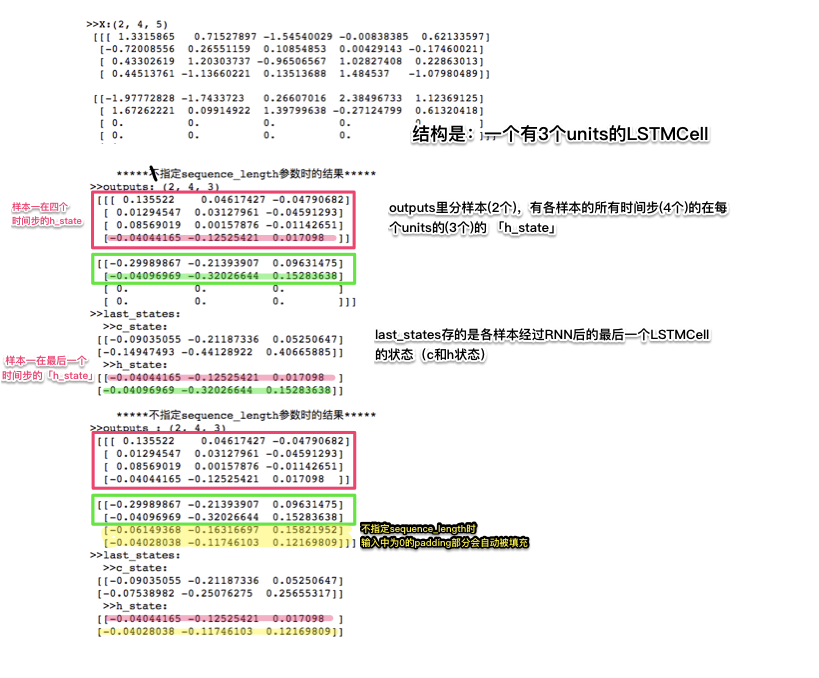

### init_state 相关问题
- `init_state`的全零初始化为什么要知道`batch_size`？
    - 这个问题还没有看到好的回答 [知乎|lstm的状态初始化为什么要有batch_size这个参数？](https://www.zhihu.com/question/67038125)


- 使用正交初始化LSTM？
    - [知乎|为什么 LSTM 在参数初始化时要使用 SVD 方法使参数正交？](https://www.zhihu.com/question/37686246)


- 返回结果是（每层layer都有）一个tuple，里面有 `c_state` 和 `h_state`，两个shape都是 `(batch_size, lstm_hidden_size)`
    - 如果多层layer使用不同的`hidden_size`那shape就是`(batch_size, 各自layer的hidden_size)`

### batch_size 和 time_step都是可变的
- 参考这个问答帖[tensorflow lstm 为什么测试时，必须保持batch_size不变](https://www.tensorflowers.cn/t/523#pid2018)

**batch_size**

认为其”不可变“是因为`dynamic_rnn`的`init_state`参数使用了`lstm_cell`自带的`zero_state`需要提供`batch_size`参数，两种方案：
- 一个是把`batch_size`作`placeholder`每次训练传进来
- 另一个是直接不用初始化了,给`dynamic_rnn`传`dtype`而不传`init_state`即可

**time_step**
- `dynamic_rnn`有一个`sequence_length`参数，




### 单层LSTM

In [41]:
tf.reset_default_graph()
np.random.seed(10)
# batch_size:2  timesteps:4 inputs:5
# 在NLP任务可以理解为：2段语料，每个语料4个词（索引），每个词5维向量
X = np.random.randn(2,4,5).astype(np.float32)
X[1, 2:] = 0  # 指定索引位置的元素全置为0
print(">>X:{}\n".format(X.shape),X)
X_lengths = [4, 2]  # 手动指定各batch里有效数据（非0数据）的步长

lstm_size = 3
lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_size)
init_state = lstm_cell.zero_state(X.shape[0], dtype=tf.float64)  # 按batch_size全0初始化state(c_state和h_state)
outputs, last_states = tf.nn.dynamic_rnn(cell=lstm_cell, 
                                         inputs=X, 
                                         initial_state=init_state,
                                         sequence_length=X_lengths)

# 不告诉rnn各batch里非0数据的长度（真实步长）
outputs_, last_states_ = tf.nn.dynamic_rnn(cell=lstm_cell, 
                                         inputs=X, 
                                         initial_state=init_state)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i = sess.run(init_state)
    print(">>init_state:\n")
    print("  >>c_state:\n", i.c)
    print("  >>h_state:\n", i.h)
    print("\n"," "*2,"*****指定sequence_length参数时的结果*****")
    o,s = sess.run([outputs,last_states])
    print(">>outputs: {}\n".format(o.shape), o)
    print(">>last_states:")
    print("  >>c_state:\n", s.c)
    print("  >>h_state:\n", s.h)

    print("\n"," "*2,"*****不指定sequence_length参数时的结果*****")
    o_,s_ = sess.run([outputs_,last_states_])
    print(">>outputs_: {}\n".format(o_.shape), o_)
    print(">>last_states:")
    print("  >>c_state:\n", s_.c)
    print("  >>h_state:\n", s_.h)
    
    print("不指定时内部会自动填充，对结果有一定影响")

>>X:(2, 4, 5)
 [[[ 1.3315865   0.71527897 -1.54540029 -0.00838385  0.62133597]
  [-0.72008556  0.26551159  0.10854853  0.00429143 -0.17460021]
  [ 0.43302619  1.20303737 -0.96506567  1.02827408  0.22863013]
  [ 0.44513761 -1.13660221  0.13513688  1.484537   -1.07980489]]

 [[-1.97772828 -1.7433723   0.26607016  2.38496733  1.12369125]
  [ 1.67262221  0.09914922  1.39799638 -0.27124799  0.61320418]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]]
>>init_state:

  >>c_state:
 [[0. 0. 0.]
 [0. 0. 0.]]
  >>h_state:
 [[0. 0. 0.]
 [0. 0. 0.]]

    *****指定sequence_length参数时的结果*****
>>outputs: (2, 4, 3)
 [[[-4.00027092e-02  7.33641521e-02 -6.64417050e-02]
  [-1.17492935e-02  5.95997232e-02 -9.63026177e-02]
  [-2.01019384e-04  3.00679067e-02 -7.42396759e-02]
  [ 1.62854652e-01 -2.04529746e-01  8.80030620e-02]]

 [[ 3.92057658e-01  2.74925040e-02  1.84443615e-01]
  [-1.33500804e-01 -3.64166122e-02  1.85011729e-01]
 

### 多层LSTM

In [40]:
tf.reset_default_graph()
np.random.seed(10)
# batch_size:2  timesteps:4 inputs:5
# 在NLP任务可以理解为：2段语料，每个语料4个词（索引），每个词5维向量
X = np.random.randn(2,4,5).astype(np.float32)
X[1, 2:] = 0  # 指定索引位置的元素全置为0
print(">>X:{}\n".format(X.shape),X)
X_lengths = [4, 2]  # 手动指定各batch里有效数据（非0数据）的步长

def make_cell(hidden_size:int, is_training:bool=True, keep_prob:float=0.8):
    cell = tf.contrib.rnn.LSTMBlockCell(hidden_size, forget_bias=0.0)
    if is_training and keep_prob < 1:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

# lstm_layer_struct = [6]*3
lstm_layer_struct = [4,5,6]
layer_num = len(lstm_layer_struct)
# mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(hidden_size) for _ in range(layer_num)], state_is_tuple=True)
mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(i) for i in lstm_layer_struct], state_is_tuple=True)
init_state = mlstm_cell.zero_state(X.shape[0], dtype=tf.float32)  # 返回的c_state和h_state都是(batch_size, hidden_size)的shape

outputs, last_states = tf.nn.dynamic_rnn(cell=mlstm_cell, 
                                         inputs=X, 
                                         initial_state=init_state,
                                         sequence_length=X_lengths)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i = sess.run(init_state)
    for j in range(layer_num):
        print(">>layer_{} init_state:".format(j))
        print(f"  >>c_state: {i[j].c.shape}\n", i[j].c)
        print(f"  >>h_state: {i[j].h.shape}\n", i[j].h)
    print("\n"," "*2,"*****指定sequence_length参数时的结果*****")
    o,s = sess.run([outputs,last_states])
    print(">>outputs: {}\n".format(o.shape), o)
    print(">>last_state: \n")
    s
    for j in range(layer_num):
        print(">>layer_{} last_state:".format(j))
        print("  >>c_state:\n", s[j].c)
        print("  >>h_state:\n", s[j].h)
    print("最后一层LSTMCell-layer的最后的h_state:\n", s[-1][1])
    print("outputs取结果:\n", o[:,-1,:])
    print("******【多层LSTM为什么outputs和last_states的结果不一致？】*****")
    

>>X:(2, 4, 5)
 [[[ 1.3315865   0.715279   -1.5454003  -0.00838385  0.621336  ]
  [-0.72008556  0.26551157  0.10854852  0.00429143 -0.17460021]
  [ 0.4330262   1.2030374  -0.96506566  1.028274    0.22863013]
  [ 0.44513762 -1.1366022   0.13513687  1.484537   -1.0798049 ]]

 [[-1.9777282  -1.7433723   0.26607016  2.3849673   1.1236912 ]
  [ 1.6726222   0.09914921  1.3979964  -0.27124798  0.6132042 ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]]
>>layer_0 init_state:
  >>c_state: (2, 4)
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
  >>h_state: (2, 4)
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
>>layer_1 init_state:
  >>c_state: (2, 5)
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
  >>h_state: (2, 5)
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
>>layer_2 init_state:
  >>c_state: (2, 6)
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
  >>h_state: (2, 6)
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

    *****指定sequence_length参数时的结果*****
>>outputs: (2, 4

(LSTMStateTuple(c=array([[-0.13037701, -0.38900766, -0.09783732, -0.3914989 ],
        [-0.17793933, -0.16858599, -0.09822684,  0.12528895]],
       dtype=float32), h=array([[-0.07532801, -0.25958276, -0.0488858 , -0.16029917],
        [-0.04850538, -0.05180939, -0.05675835,  0.09599842]],
       dtype=float32)),
 LSTMStateTuple(c=array([[ 0.1054725 , -0.02768842, -0.01605159, -0.15950125, -0.01322822],
        [ 0.0046655 , -0.0454566 , -0.02333709, -0.00293432, -0.0451175 ]],
       dtype=float32), h=array([[ 0.04700918, -0.01477722, -0.00778601, -0.07789692, -0.00657268],
        [ 0.00233638, -0.02223791, -0.01144237, -0.00142828, -0.02310358]],
       dtype=float32)),
 LSTMStateTuple(c=array([[-0.00571135, -0.00171916, -0.00352988, -0.0101656 , -0.01930854,
          0.02133612],
        [ 0.00246346,  0.0005158 ,  0.00279958,  0.00543222, -0.00594782,
          0.00384446]], dtype=float32), h=array([[-0.0028245 , -0.00086311, -0.00174431, -0.00508022, -0.0096066 ,
          0.010

>>layer_0 last_state:
  >>c_state:
 [[-0.13037701 -0.38900766 -0.09783732 -0.3914989 ]
 [-0.17793933 -0.16858599 -0.09822684  0.12528895]]
  >>h_state:
 [[-0.07532801 -0.25958276 -0.0488858  -0.16029917]
 [-0.04850538 -0.05180939 -0.05675835  0.09599842]]
>>layer_1 last_state:
  >>c_state:
 [[ 0.1054725  -0.02768842 -0.01605159 -0.15950125 -0.01322822]
 [ 0.0046655  -0.0454566  -0.02333709 -0.00293432 -0.0451175 ]]
  >>h_state:
 [[ 0.04700918 -0.01477722 -0.00778601 -0.07789692 -0.00657268]
 [ 0.00233638 -0.02223791 -0.01144237 -0.00142828 -0.02310358]]
>>layer_2 last_state:
  >>c_state:
 [[-0.00571135 -0.00171916 -0.00352988 -0.0101656  -0.01930854  0.02133612]
 [ 0.00246346  0.0005158   0.00279958  0.00543222 -0.00594782  0.00384446]]
  >>h_state:
 [[-0.0028245  -0.00086311 -0.00174431 -0.00508022 -0.0096066   0.01060014]
 [ 0.00123821  0.00025767  0.00138981  0.00272048 -0.00296256  0.00191814]]
最后一层LSTMCell-layer的最后的h_state:
 [[-0.0028245  -0.00086311 -0.00174431 -0.00508022 -0.009

### 多层LSTM & 可变batch_size, time_step
- 不提供init_state，让`dynamic_rnn`自行初始化（需提供`dtype`）


模拟数据准备

In [60]:
np.random.seed(10)
# batch_size:2  timesteps:4 inputs:5
# 在NLP任务可以理解为：4段语料，每个语料4个词（索引），每个词5维向量
# batch_size, time_step, input
X = np.random.randn(4,4,5).astype(np.float32)
# 构造全零的行，即time_step不同
empty_row = [0]*X.shape[-1]
X[1, 2:] = empty_row
X[3, 3:] = empty_row
print(f">>X:{X.shape}\n",X)

>>X:(4, 4, 5)
 [[[ 1.3315865   0.715279   -1.5454003  -0.00838385  0.621336  ]
  [-0.72008556  0.26551157  0.10854852  0.00429143 -0.17460021]
  [ 0.4330262   1.2030374  -0.96506566  1.028274    0.22863013]
  [ 0.44513762 -1.1366022   0.13513687  1.484537   -1.0798049 ]]

 [[-1.9777282  -1.7433723   0.26607016  2.3849673   1.1236912 ]
  [ 1.6726222   0.09914921  1.3979964  -0.27124798  0.6132042 ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.66023153 -0.3508719  -0.93943334 -0.4893372  -0.8045911 ]
  [-0.21269764 -0.33914024  0.31216994  0.56515265 -0.14742026]
  [-0.02590534  0.2890942  -0.5398791   0.70816004  0.8422247 ]
  [ 0.2035808   2.3947036   0.91745895 -0.11227247 -0.36218044]]

 [[-0.23218225 -0.5017289   1.1287851  -0.69781005 -0.08112218]
  [-0.5292961   1.0461829  -1.418556   -0.36249918 -0.12190569]
  [ 0.3193564   0.4609029  -0.2157899   0.98907244  0.31475377]
  [ 0.          0. 

部分参数准备

In [101]:
# X_length
time_steps = [len([i for i in sample_seq if (i != empty_row).all()]) for sample_seq in X]  # 手动指定各 sample_seq 里有效数据（非0数据）的步长
batch_size = X.shape[0]
lstm_layer_struct = [4,5,6]
layer_num = len(lstm_layer_struct)
encode_size=X.shape[-1]
print(f">>time_steps:{time_steps}")
print(f">>batch_size:{batch_size}")
print(f">>lstm_layer_struct:{lstm_layer_struct}")
print(f">>encode_size:{encode_size}")

>>time_steps:[4, 2, 4, 3]
>>batch_size:4
>>lstm_layer_struct:[4, 5, 6]
>>encode_size:5


构造模型

In [102]:
tf.reset_default_graph()


inpBS = tf.placeholder(tf.int32, [], name="batch_size")
inpTS = tf.placeholder(tf.int32, [None], name="time_steps")
inpX = tf.placeholder(tf.float32, shape=(None, None, encode_size), name="inpX")
inpY = tf.placeholder(tf.float32, shape=(None), name="inpY")

def make_cell(hidden_size:int, is_training:bool=True, keep_prob:float=0.8):
    cell = tf.contrib.rnn.LSTMBlockCell(hidden_size, forget_bias=0.0)
    if is_training and keep_prob < 1:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(i) for i in lstm_layer_struct], state_is_tuple=True)

outputs, last_states = tf.nn.dynamic_rnn(cell=mlstm_cell, 
                                         inputs=inpX, 
                                         dtype=tf.float32,
                                         sequence_length=inpTS)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("\n"," "*2,"*****指定sequence_length参数时的结果*****")
    o,s = sess.run([outputs,last_states], feed_dict={inpX: X, inpTS:time_steps})
    print(">>outputs: {}\n".format(o.shape), o)
    print(">>last_state: \n")
    for j in range(len(lstm_layer_struct)):
        print(">>layer_{} last_state:".format(j))
        print("  >>c_state:\n", s[j].c)
        print("  >>h_state:\n", s[j].h)
    print("最后一层LSTMCell-layer的最后的h_state:\n", s[-1][1])
    print("outputs取结果:\n", o[:,-1,:])
    print("******【多层LSTM为什么outputs和last_states的结果不一致？】*****")
    


    *****指定sequence_length参数时的结果*****
>>outputs: (4, 4, 6)
 [[[-0.0000000e+00 -1.2860976e-03 -0.0000000e+00 -0.0000000e+00
    6.5237395e-03 -4.0416806e-03]
  [-0.0000000e+00 -3.7991023e-04 -5.1117572e-03 -0.0000000e+00
    5.5675451e-03 -0.0000000e+00]
  [-8.8043371e-04 -1.7873832e-03 -3.3563836e-03 -2.1273063e-03
    8.9583527e-03 -9.6272035e-03]
  [-4.6955873e-04 -0.0000000e+00 -4.7586719e-03 -0.0000000e+00
    0.0000000e+00 -1.1224565e-02]]

 [[ 3.9885729e-03  0.0000000e+00  1.9260012e-03  0.0000000e+00
   -3.0279782e-04 -2.0173802e-03]
  [-1.5676090e-03 -0.0000000e+00 -1.2291577e-03 -1.4616082e-03
    9.3021203e-04 -8.6546730e-04]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
    0.0000000e+00  0.0000000e+00]]

 [[-0.0000000e+00 -2.2817521e-04  6.7885761e-04 -0.0000000e+00
   -2.6789031e-03  0.0000000e+00]
  [-2.1678691e-03 -1.4110510e-03  8.7989531e-05 -1.5911483e-03

### 测试 | 
- 不提供 init_state、多层不同hidden_size

`initial_state`
- 指定`dtype`的话，可以不提供这个参数
- 这个初始化状态，一般用全零 `init_s = lstem_cell.zero_state(batch_size)` 来获得

In [33]:
tf.reset_default_graph()
np.random.seed(10)
# batch_size:2  timesteps:4 inputs:5
# 在NLP任务可以理解为：2段语料，每个语料4个词（索引），每个词5维向量
X = np.random.randn(2,4,5).astype(np.float32)
X[1, 2:] = 0  # 指定索引位置的元素全置为0
print(">>X:{}\n".format(X.shape),X)
X_lengths = [4, 2]  # 手动指定各batch里有效数据（非0数据）的步长

lstm_size = 3
lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_size)
# init_state = lstm_cell.zero_state(X.shape[0], dtype=tf.float64)  # 按batch_size全0初始化state(c_state和h_state)
outputs, last_states = tf.nn.dynamic_rnn(cell=lstm_cell, 
                                         inputs=X, 
                                         dtype=tf.float32,
                                         sequence_length=X_lengths)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("\n"," "*2,"*****不提供init_state，用dtype来进行dynamic_rnn*****")
    o,s = sess.run([outputs,last_states])
    print(">>outputs: {}\n".format(o.shape), o)
    print(">>last_states:")
    print("  >>c_state:\n", s.c)
    print("  >>h_state:\n", s.h)

>>X:(2, 4, 5)
 [[[ 1.3315865   0.715279   -1.5454003  -0.00838385  0.621336  ]
  [-0.72008556  0.26551157  0.10854852  0.00429143 -0.17460021]
  [ 0.4330262   1.2030374  -0.96506566  1.028274    0.22863013]
  [ 0.44513762 -1.1366022   0.13513687  1.484537   -1.0798049 ]]

 [[-1.9777282  -1.7433723   0.26607016  2.3849673   1.1236912 ]
  [ 1.6726222   0.09914921  1.3979964  -0.27124798  0.6132042 ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]]

    *****不提供init_state，用dtype来进行dynamic_rnn*****
>>outputs: (2, 4, 3)
 [[[-0.19323589 -0.29735395 -0.11635954]
  [-0.11534447 -0.13314529 -0.16315363]
  [-0.25973982 -0.20278847 -0.18915269]
  [-0.03248867  0.05884563 -0.13254341]]

 [[-0.07206876  0.14825338  0.0237984 ]
  [ 0.06081879 -0.02563954  0.3016996 ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]
>>last_states:
  >>c_state:
 [[-0.12716724  0.12146232 -0.2257516 ]
 [ 0.

### 对`dynamic_rnn`的展开实现

In [ ]:
# **步骤6：方法一，调用 dynamic_rnn() 来让我们构建好的网络运行起来
# ** 当 time_major==False 时， outputs.shape = [batch_size, timestep_size, hidden_size] 
# ** 所以，可以取 h_state = outputs[:, -1, :] 作为最后输出
# ** state.shape = [layer_num, 2, batch_size, hidden_size], 
# ** 或者，可以取 h_state = state[-1][1] 作为最后输出
# ** 最后输出维度是 [batch_size, hidden_size]
# outputs, state = tf.nn.dynamic_rnn(mlstm_cell, inputs=X, initial_state=init_state, time_major=False)
# h_state = outputs[:, -1, :]  # 或者 h_state = state[-1][1]

# *************** 为了更好的理解 LSTM 工作原理，我们把上面 步骤6 中的函数自己来实现 ***************
# 通过查看文档你会发现， RNNCell 都提供了一个 __call__()函数（见最后附），我们可以用它来展开实现LSTM按时间步迭代。
# **步骤6：方法二，按时间步展开计算
outputs = list()
state = init_state
with tf.variable_scope('RNN'):
    for timestep in range(timestep_size):
        if timestep > 0:
            tf.get_variable_scope().reuse_variables()
        # 这里的state保存了每一层 LSTM 的状态
        (cell_output, state) = mlstm_cell(X[:, timestep, :], state)
        outputs.append(cell_output)
h_state = outputs[-1]
tf.summary.histogram("h_state",h_state)

## LSTM拟合多个数累加的序列
- 两个正整数都是`[0, 9]` 10种
- 对应Y的范围 `[0, 18]` 19种

### 数据准备

In [153]:
num_inp = 10  # 输入的两个加和数有10种取值（包含0）
num_class_2 = 2*(num_inp-1) + 1 # 二元加法和的结果有19种（包含0）
num_class_3 = 3*(num_inp-1) + 1 # 三元加法的和有 每个数最大是9，三元加法最大为27，再包含0
# a,b,a+b,2(a+b) | 这个序列取 time_step=3 也是有意义的：第三个数为前两个数之和
def get_one_sample():
    a = np.random.randint(1, num_inp) # 第一个数不为0
    b = np.random.randint(0, num_inp)
    if b == 0:
        # 如果b为0，c直接为0，表示最后两位都是 padding 的结果
        c = 0
    else:
        # 就算b不为0，c也有几率为0，表示最后一位是padding的结果
        c = np.random.choice([0,a+b])
    d = a + b + c
    return np.array([a,b,c,d])

# a,b,c, a+b+c | 这个序列取 time_step=3 没有意义：第三个数是随机的，所以可以验证如果LSTM的训练数据只见过三元加法而没有见过二元加法，预测的时候提供二元数据是否能算对？
def get_one_sample_another():
    a = np.random.randint(0,num_inp)  # 
    b = np.random.randint(1,num_inp)
    c = np.random.randint(1,num_inp)
    d = a+b+c
    return np.array([a,b,c,d])

data_ = np.array([get_one_sample() for _ in range(100*10000)])

data_verify = data_[[row[0] in [2,5,9] for row in data_]]  # 保留2+n,5+n,9+n的样本作为verify
data_train = data_[[row[0] not in [2,5,9] for row in data_]]  # 训练数据只用非2+n、5+n、9+n的数据
dataX = data_train[:,:-1]
dataY = data_train[:,-1]

print(f">>> data_ 中 最后一位是padding的数据: {data_[data_[:,-2]==0].shape}\n",data_[data_[:,-2]==0])
print(f">>> data_ 中 最后两位都是padding的数据: {data_[data_[:,-3]==0].shape}\n",data_[data_[:,-3]==0])
print(">>> data_ 前三个示例: {}\n".format(data_.shape),data_[:3])
print(">>> dataX 前三个示例: {}\n".format(dataX.shape),dataX[:3])
print(">>> dataY 前三个示例: {}\n".format(dataY.shape),dataY[:3])
print(">>> dataY 目前有{}种取值, 理论上应有{}种取值".format(np.unique(dataY.flatten()).shape[0], num_class_3))

>>> data_ 中 最后一位是padding的数据: (550125, 4)
 [[ 2  1  0  3]
 [ 9  9  0 18]
 [ 3  2  0  5]
 ...
 [ 1  4  0  5]
 [ 4  2  0  6]
 [ 2  5  0  7]]
>>> data_ 中 最后两位都是padding的数据: (99943, 4)
 [[4 0 0 4]
 [9 0 0 9]
 [7 0 0 7]
 ...
 [5 0 0 5]
 [5 0 0 5]
 [4 0 0 4]]
>>> data_ 前三个示例: (1000000, 4)
 [[ 2  1  0  3]
 [ 9  9  0 18]
 [ 8  2 10 20]]
>>> dataX 前三个示例: (666933, 3)
 [[ 8  2 10]
 [ 3  2  0]
 [ 6  8  0]]
>>> dataY 前三个示例: (666933,)
 [20  5 14]
>>> dataY 目前有26种取值, 理论上应有28种取值


### 网络搭建 | LSTM


np.nonzero的示例

In [ ]:
np.array([0,17,8,9]).nonzero()
np.array([[0,17,8,9],[0,17,8,9]]).nonzero()

In [154]:
tf.reset_default_graph()
# batch_size在全零初始化时用到了，所以必须指定（不能由shape的None自动推理得到）
# 为了保证灵活性，用placeholder传进来
inpTS = tf.placeholder(tf.int32, [None], name="time_steps")
inpX = tf.placeholder(tf.int32, shape=(None, None), name="inpX")
inpY = tf.placeholder(tf.int32, shape=(None), name="inpY")
X = tf.one_hot(inpX,depth=num_class_2) # x 取值 [0,18]
Y = tf.one_hot(inpY,depth=num_class_3)

# 单层LSTM
lstm_size = 10
lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_size)
outputs, last_states = tf.nn.dynamic_rnn(cell=lstm_cell, 
                                           inputs=X,
                                           dtype=tf.float32,
                                           sequence_length=inpTS,  # 变长time_steps
                                          )


default_feed_dict = {inpX:dataX[:200], inpY:dataY[:200], inpTS:[len(sample_seq.nonzero()[0]) for sample_seq in dataX[:200]]}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x,y,inpX_,inpTS_,inpY_ = sess.run([X,Y,inpX,inpTS,inpY], feed_dict=default_feed_dict)
    print(">>> tf.one_hot(X)的效果:{}\n".format(x.shape),x[:4])
    print(">>> tf.one_hot(Y)的效果:{}\n".format(y.shape),y[:4])
    print(f">>> inpTS_: {inpTS_.shape}")
    print(">>>演示包含0的样本（即time_step不同）")
    contains0=[idx for idx,i in enumerate(inpX_) if 0 in i][:8]
    print("    X中包含0 (padding)的如下:\n", inpX_[contains0])
    print("    Y为:\n",inpY_[contains0])
    print("    索引为:\n",inpTS_[contains0])
    
    o_,s_ = sess.run([outputs,last_states], feed_dict=default_feed_dict)
    print(">>outputs_: {}\n".format(o_.shape), o_[:3])
    print(">>last_states:")
    print("  >>c_state: {}\n".format(s_.c.shape),s_.c[:3])
    print("  >>h_state: {}\n".format(s_.h.shape),s_.h[:3])
    print("本次LSTM计算结果即上述 h_state")

>>> tf.one_hot(X)的效果:(200, 3, 19)
 [[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
>>> tf.one_hot(Y)的效果:(200, 28)
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0

### 网络搭建 | 输出及CE
- softmax 输出
- CE loss & Adamopt

In [155]:
# 取出LSTM的最后一个 h_state 做softmax将LSTM维度(lstm_size)的输出归一化到最终分类数(num_class)维度
softmax_w = tf.Variable(tf.truncated_normal([lstm_size, num_class_3], stddev=0.1))
softmax_b = tf.Variable(tf.zeros(num_class_3))
logits = tf.matmul(last_states.h, softmax_w) + softmax_b  # 这里单独拿一下logits目的是为了后面使用tf的API计算CE
pred = tf.nn.softmax(logits, name='predictions')
print(">>> 构造softmax: [inp.shape]:{}, [w.shape]:{}, [b.shape]:{}".format(last_states_.h.shape, softmax_w.shape,softmax_b.shape))
print(">>> softmax logits结果:{}, softmax最后结果: {}".format(logits.shape,pred.shape))

# 计算CE
loss_ = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y)
loss = tf.reduce_mean(loss_)  # 一个标量数
print(">>> 各样本loss_: {}, reduce_mean后的loss: {} loss_type: {}".format(loss_.shape, loss.shape, type(loss)))

# 优化loss
grad_clip=5  # 梯度裁剪避免爆炸
tvars = tf.trainable_variables()
grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
train_op = tf.train.AdamOptimizer(0.01)
optimizer = train_op.apply_gradients(zip(grads, tvars))

>>> 构造softmax: [inp.shape]:(?, 10), [w.shape]:(10, 28), [b.shape]:(28,)
>>> softmax logits结果:(?, 28), softmax最后结果: (?, 28)
>>> 各样本loss_: (?,), reduce_mean后的loss: () loss_type: <class 'tensorflow.python.framework.ops.Tensor'>


### 训练

In [156]:
saver = tf.train.Saver(max_to_keep=4)
batch_size = 400
epochs = 2
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    global_cnt = 0
    for e in range(epochs):
        dataX_iter = iter(dataX)
        dataY_iter = iter(dataY)
        cnt=0
        while True:
            X_batch = np.array(list(itertools.islice(dataX_iter, batch_size)))
            Y_batch = np.array(list(itertools.islice(dataY_iter, batch_size)))
            if len(X_batch)>0 and len(Y_batch)>0:
                feed = {inpX:X_batch, inpY:Y_batch, inpTS:[len(sample_seq.nonzero()[0]) for sample_seq in X_batch]}
                b_loss,b_state,_ = sess.run([loss,last_states,optimizer], feed_dict = feed)
                if cnt % 100 == 0:
                    zprint("[e-b]: {:0>2}-{:0>4} [loss]: {}".format(e,cnt,b_loss))
                    _ = saver.save(sess, "./tmp/lstmModel/predict_add.ckpt", global_step=global_cnt)
                cnt += 1
                global_cnt += 1
            else:
                break
    _ = saver.save(sess, "./tmp/lstmModel/predict_add.ckpt", global_step=global_cnt)
    X_infer = np.array([[j, i] for j in [2,5,9] for i in range(num_inp)])
    pred_res, Y_inferred = sess.run([pred, tf.argmax(pred,1)],feed_dict={inpX:X_infer, inpTS:[len(sample_seq.nonzero()[0]) for sample_seq in X_infer]})
#     print(">>> 加法测试数据X_infer: {}\n".format(X_infer.shape), X_infer)
#     print(">>> LSTM预测加法结果 argmax(softmax): {}\n".format(Y_inferred.shape), Y_inferred)
    print(">>> 二元加法测试结果的直观展示:\n",np.array(list(zip(X_infer,Y_inferred))))
    print(
        """这里注意到，9+9是样本中完全没有出现过的（其他如5+4虽没出现过但是4+5是出现过的）
        实验发现增加样本量&降低学习率能够让9+9更接近真实值。
        10w样本&lr=0.1  ==> 9+9=8
        50w样本&lr=0.01 ==> 9+9=17
        """)
    print("\n其他非重要信息:")
    print(">>> 预测结果 softmax的top5: {}\n".format(pred_res.shape), pred_res[:5])

|2019-10-22 16:35:04| [e-b]: 00-0000 [loss]: 3.107638359069824
|2019-10-22 16:35:04| [e-b]: 00-0100 [loss]: 1.2960842847824097
|2019-10-22 16:35:05| [e-b]: 00-0200 [loss]: 0.6012622714042664
|2019-10-22 16:35:06| [e-b]: 00-0300 [loss]: 0.260280042886734
|2019-10-22 16:35:07| [e-b]: 00-0400 [loss]: 0.1584692746400833
|2019-10-22 16:35:07| [e-b]: 00-0500 [loss]: 0.0977967381477356
|2019-10-22 16:35:08| [e-b]: 00-0600 [loss]: 0.08005472272634506
|2019-10-22 16:35:09| [e-b]: 00-0700 [loss]: 0.0692838579416275
|2019-10-22 16:35:10| [e-b]: 00-0800 [loss]: 0.05483916401863098
|2019-10-22 16:35:10| [e-b]: 00-0900 [loss]: 0.05490957200527191
|2019-10-22 16:35:11| [e-b]: 00-1000 [loss]: 0.041280146688222885
|2019-10-22 16:35:12| [e-b]: 00-1100 [loss]: 0.037771716713905334
|2019-10-22 16:35:12| [e-b]: 00-1200 [loss]: 0.03840332478284836
|2019-10-22 16:35:13| [e-b]: 00-1300 [loss]: 0.03684227168560028
|2019-10-22 16:35:14| [e-b]: 00-1400 [loss]: 0.03495681658387184
|2019-10-22 16:35:15| [e-b]: 00-

In [164]:
X_infer.shape

(30, 2)

### 预测

In [170]:
class tempObj:
    def __init__(self):
        saver = tf.train.Saver()
        self.graph = tf.get_default_graph()
        with self.graph.as_default():
            self.sess = tf.Session()
            saver.restore(self.sess, tf.train.latest_checkpoint('./tmp/lstmModel'))
            self.inpX = self.graph.get_tensor_by_name("inpX:0")
            self.inpY = self.graph.get_tensor_by_name("inpY:0")
            self.inpTS = self.graph.get_tensor_by_name("time_steps:0")
            self.pred = self.graph.get_tensor_by_name("predictions:0")

    def predict(self,X_infer):
        feed = {self.inpX:X_infer, self.inpTS:[len(sample_seq.nonzero()[0]) for sample_seq in X_infer]}
        res = self.sess.run(tf.argmax(self.pred,1), feed_dict=feed)
        return res
calc = tempObj()

INFO:tensorflow:Restoring parameters from ./tmp/lstmModel/predict_add.ckpt-3336


In [171]:
inp = np.array([[1,2,3],[2,2,2]])
inp
[len(sample_seq.nonzero()[0]) for sample_seq in inp]
calc.predict(inp)

array([[1, 2, 3],
       [2, 2, 2]])

[3, 3]

array([6, 8])

In [ ]:
X_infer = np.array([[j, i] for j in [2,5,9] for i in range(num_inp)])
pred_res, Y_inferred = sess.run([pred, tf.argmax(pred,1)],feed_dict={inpBS:X_infer.shape[0],inpX:X_infer})
#     print(">>> 加法测试数据X_infer: {}\n".format(X_infer.shape), X_infer)
#     print(">>> LSTM预测加法结果 argmax(softmax): {}\n".format(Y_inferred.shape), Y_inferred)
print(">>> 加法测试结果的直观展示:\n",np.array(list(zip(X_infer,Y_inferred))))
print(
    """这里注意到，9+9是样本中完全没有出现过的（其他如5+4虽没出现过但是4+5是出现过的）
    实验发现增加样本量&降低学习率能够让9+9更接近真实值。
    10w样本&lr=0.1  ==> 9+9=8
    50w样本&lr=0.01 ==> 9+9=17
    """)
print("\n其他非重要信息:")
print(">>> 预测结果 softmax的top5: {}\n".format(pred_res.shape), pred_res[:5])